# Analyzing differences in cases and deaths after policy implementation



In this notebook, we investigate if there is an observable correlation between the implementation of some policy and the change in cases or deaths afterward.

To achieve this, we will:

1. Look at every policy in the policy dataset.
2. Identify all instances where the policy was implemented at the state or county level.
3. Measure the difference in cases and deaths from the day the policy was implemented to $m$ days afterward.

## Mathematical Formulation

Let $c_t$ be the number of cases on the day a policy was implemented, and $c_{t+m}$ be the number of cases $m$ days after policy implementation. We define:

- First-order difference: $\frac{c_{t+m} - c_t}{m}$
- Second-order difference: $\frac{(c_{t+1} - c_t) - (c_{t+m+1} - c_{t+m})}{m}$

Similarly for deaths.

## Index

This notebook is divided into three parts:

1. Histograms - Calculate the 1st and 2nd order differences at 14 days and plot histograms of those differences.
2. Confidence Intervals (CIs) at 14 days - Plot CIs at 14 days and identify significant differences.
3. Varying Lag Analysis - Plot CIs while varying the lag between 4 and 30 days.

## Setup Instructions

If this notebook is being run from a fresh install of the project, make sure to un-comment the cell below and run the script (this should take about 15 minutes). This generates the data needed for Section 3 of the notebook


In [14]:
!python scripts/differencing.py

                     ./o.
                   ./sssso-
                 `:osssssss+-
               `:+sssssssssso/.
             `-/ossssssssssssso/.
           `-/+sssssssssssssssso+:`
         `-:/+sssssssssssssssssso+/.
       `.://osssssssssssssssssssso++-
      .://+ssssssssssssssssssssssso++:
    .:///ossssssssssssssssssssssssso++:
  `:////ssssssssssssssssssssssssssso+++.
`-////+ssssssssssssssssssssssssssso++++-
 `..-+oosssssssssssssssssssssssso+++++/`
   ./++++++++++++++++++++++++++++++/:.
  `:::::::::::::::::::::::::------``
╭ ──────┉────── • ──────┉────── ╮ 
 · OS: EndeavourOS Linux x86_64 
 · Host: 20HGS1CM00 ThinkPad T470s 
 · Shell: fish 3.7.1 
 · WM: i3 
 · Icons: breeze-dark [GTK2/3] 
 · Terminal: tmux 
 · CPU: Intel i5-7300U (4) @ 3.500GHz 
 · GPU: Intel HD Graphics 620 
 · Memory: 5383MiB / 15743MiB 






100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 407.85it/s]


# 0. Imports

In [2]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
from covid_project import data_cleaning as dc
from covid_project import diffs as deltas
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt
import os

In [3]:
case_data = dc.clean_covid_data()
policy_data = dc.clean_policy_data()

# 1. Investigate correlations after 14 days

In [4]:
correlated_df, state_cases_dict = deltas.calculate_diffs(
    case_df = case_data,
    policy_df = policy_data,
    measure_period = 14,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # lots of numpy warnings for mean of empty slice

    delta_stats, raws = deltas.calc_diff_stats_v1(correlated_df, measure_period=14)

  0%|          | 0/50 [00:00<?, ?it/s]

First, check out a histogram of these differences and look for anything significant

/tmp/ipykernel_62759/2274434174.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=4, figsize=[20, 3])


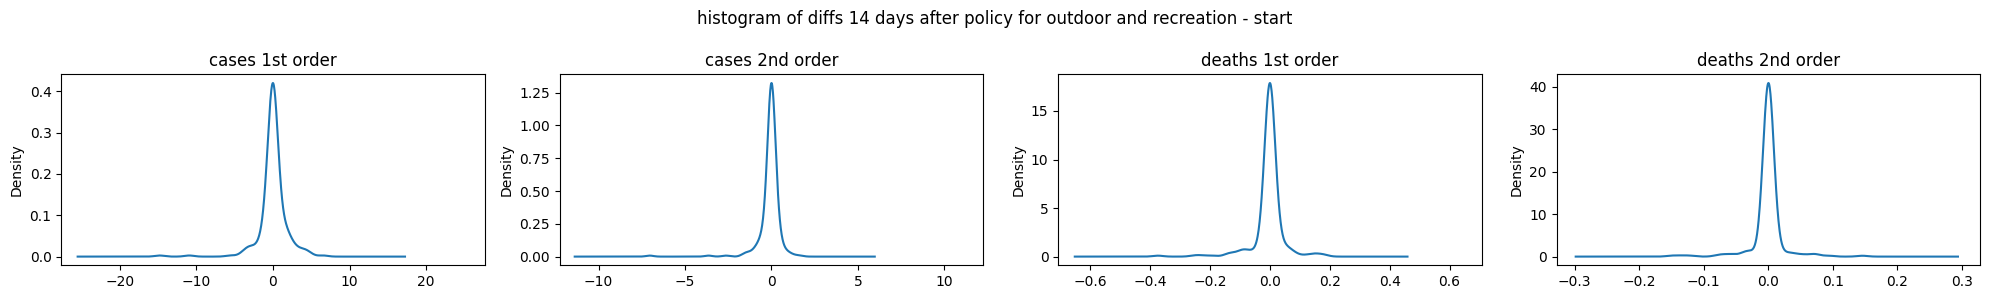

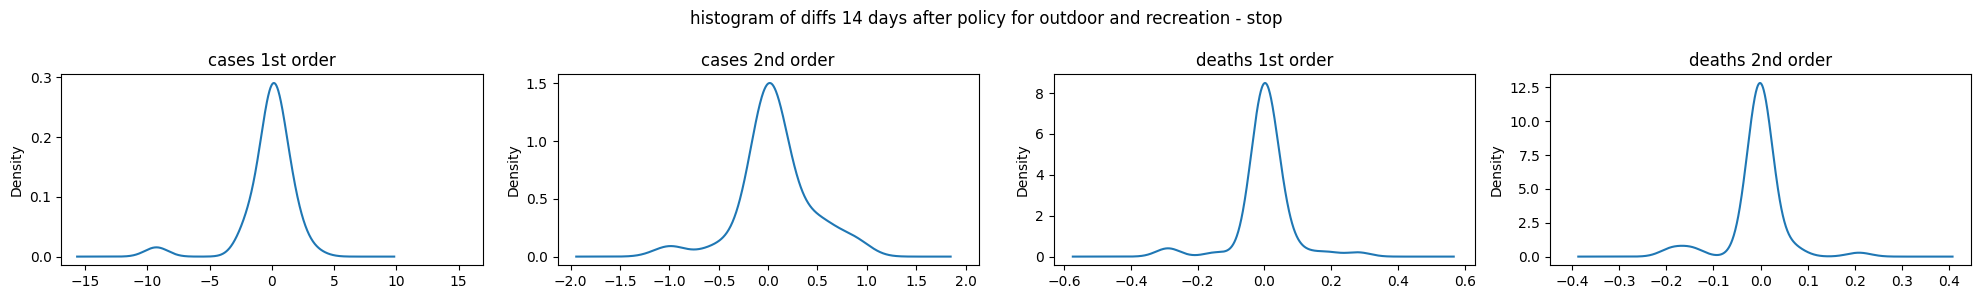

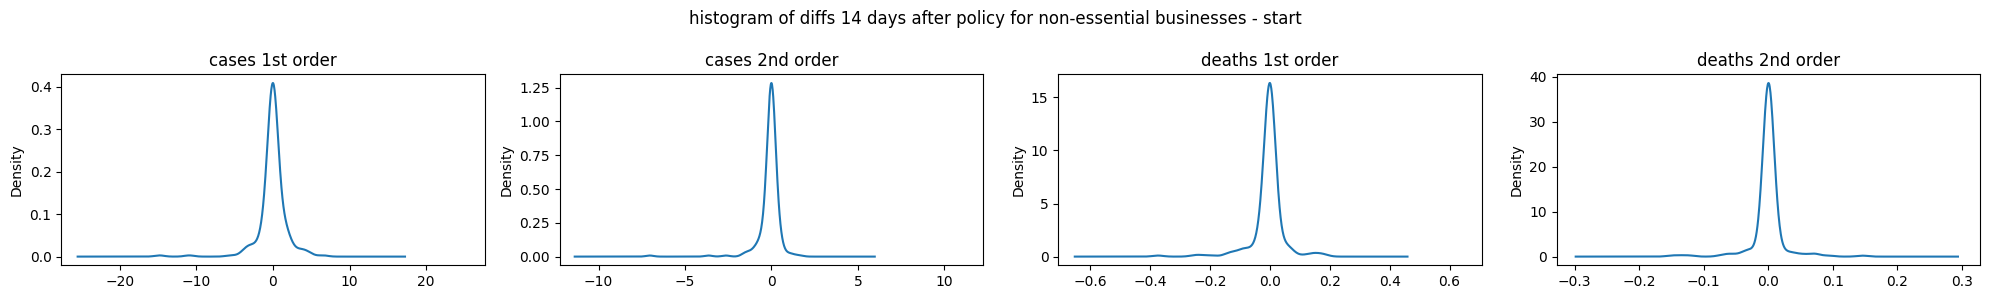

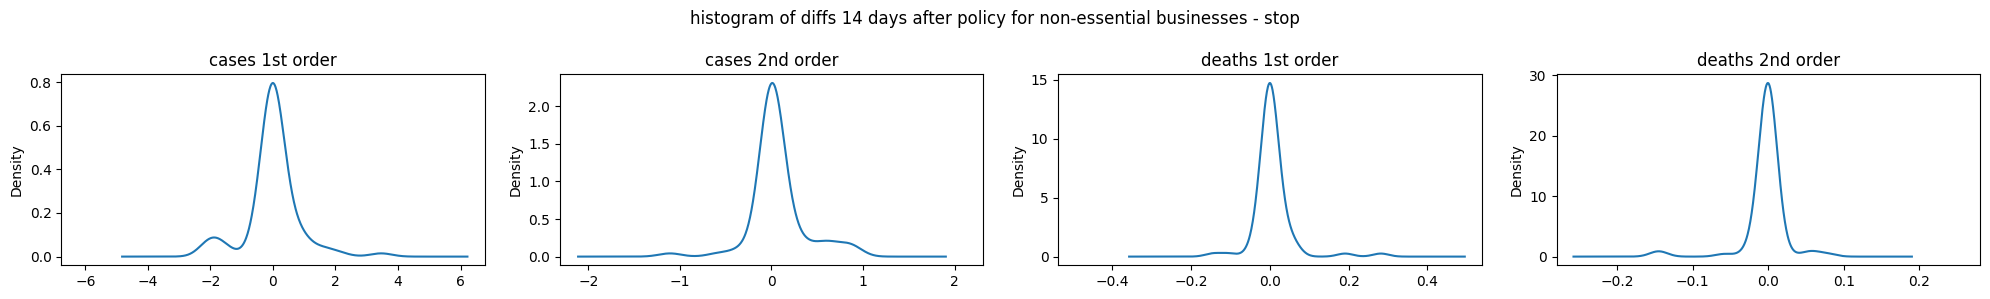

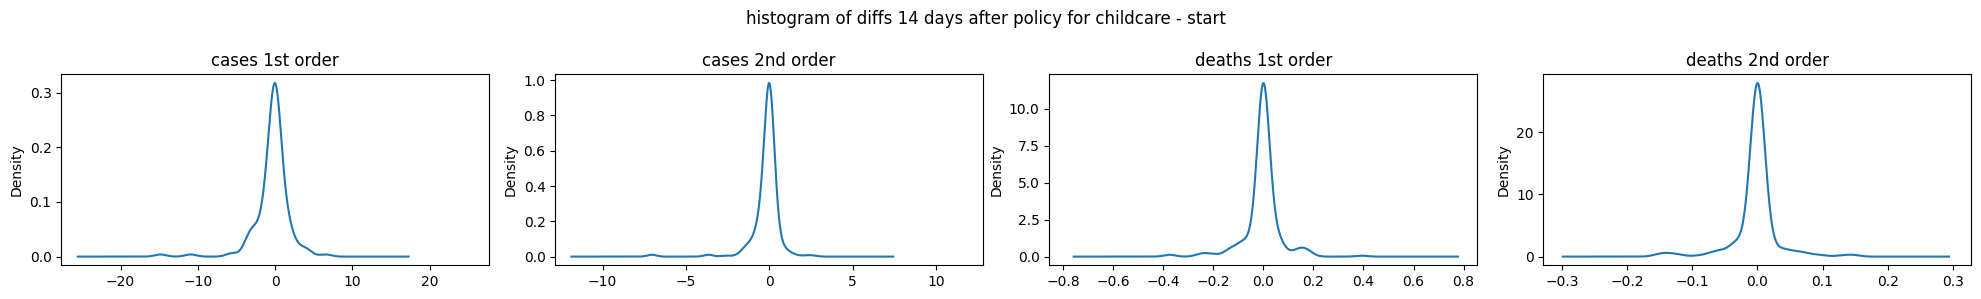

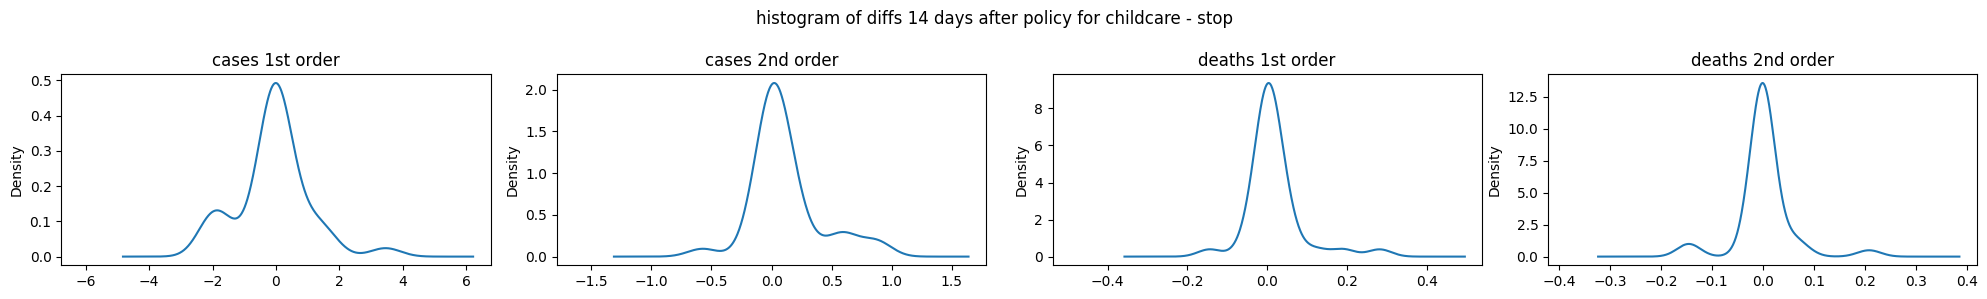

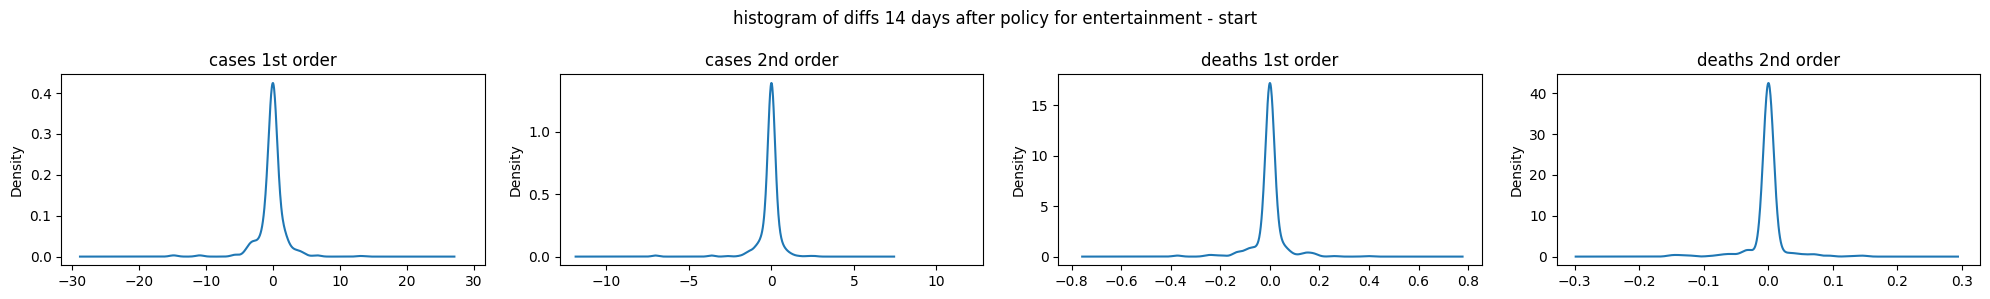

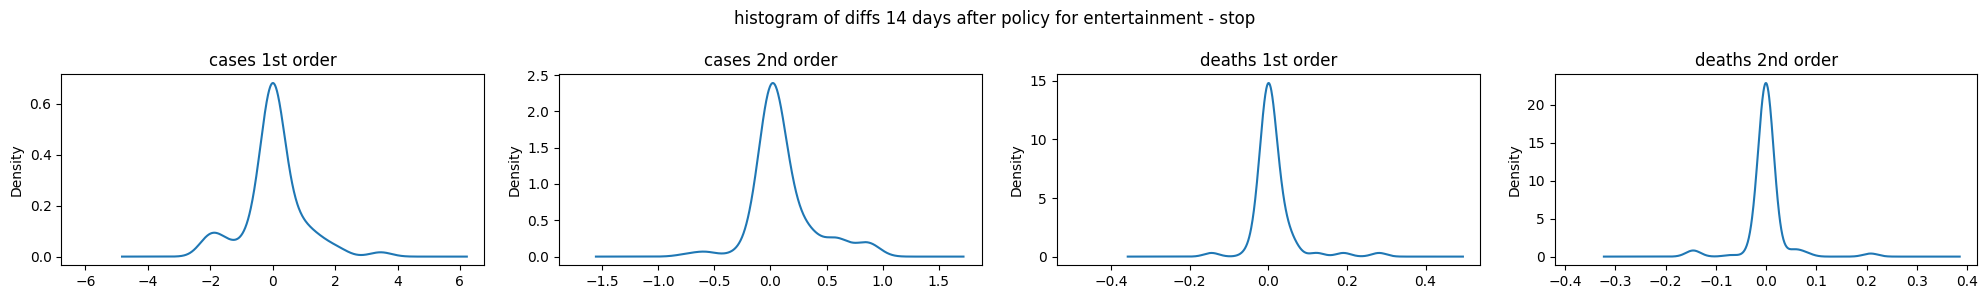

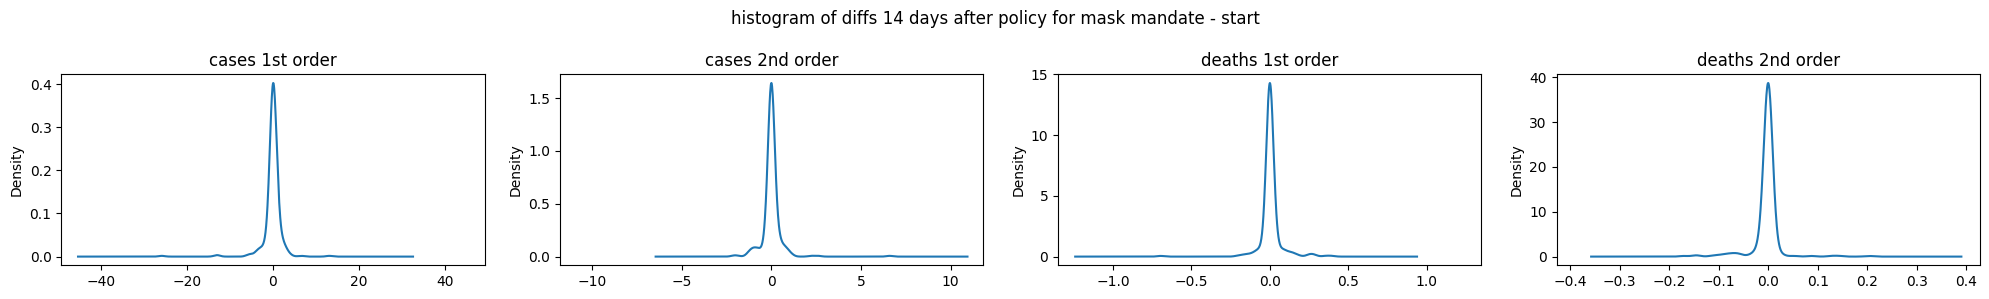

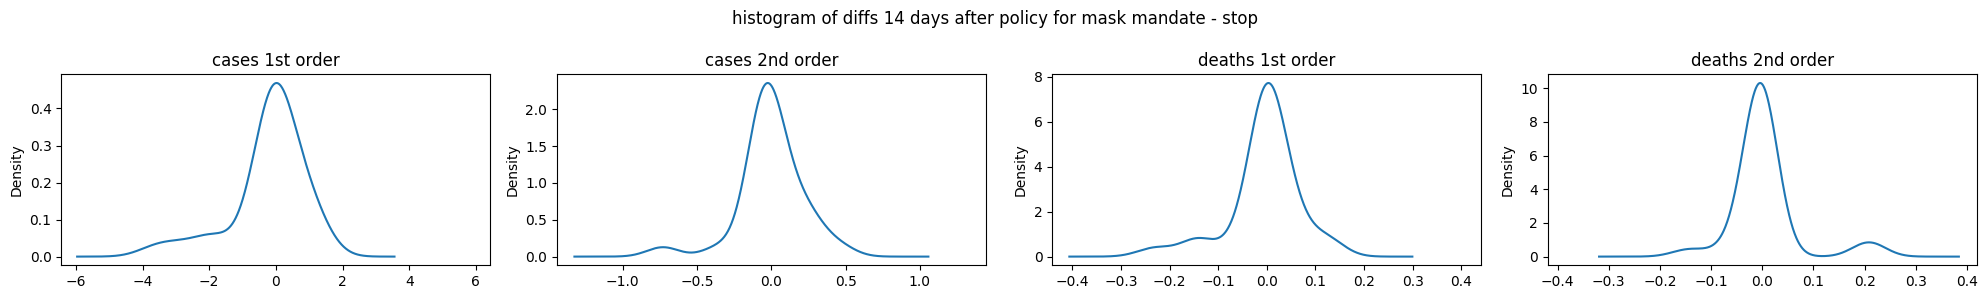

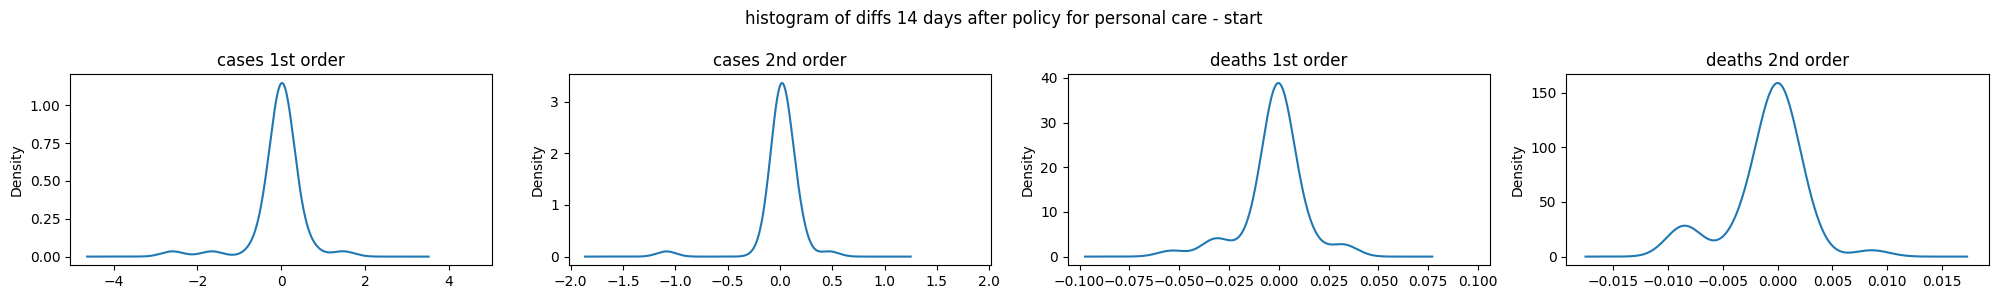

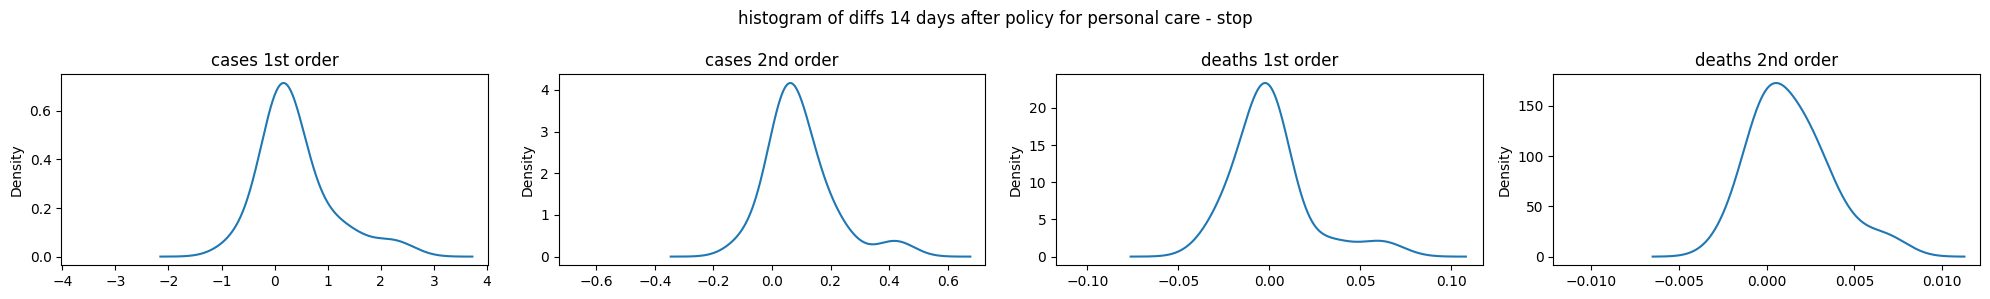

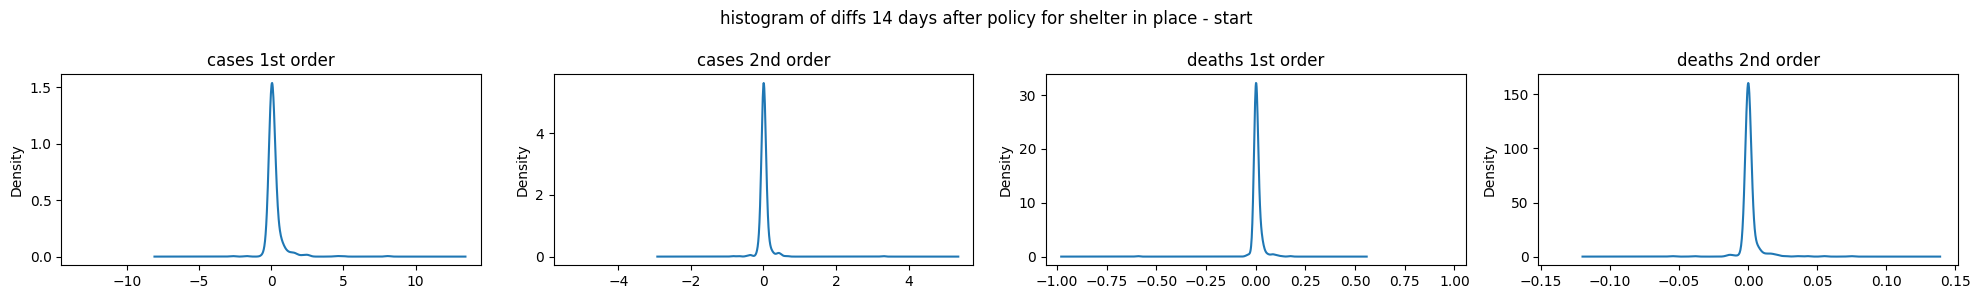

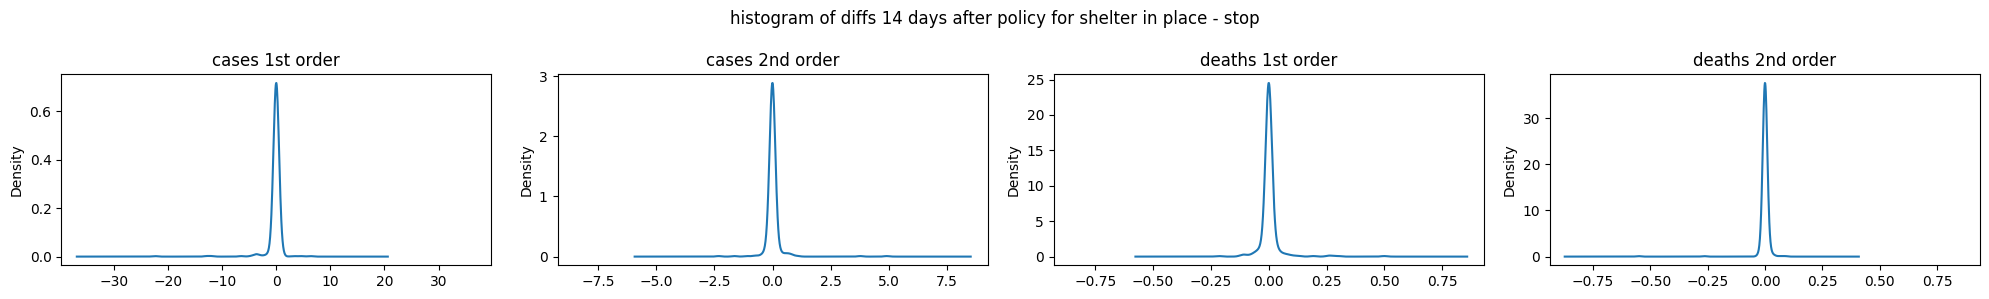

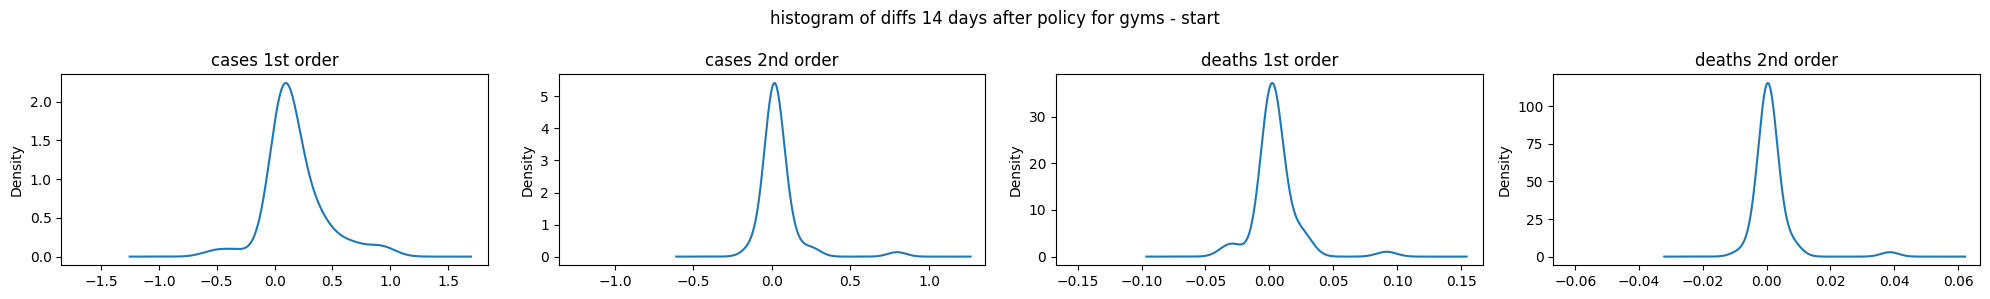

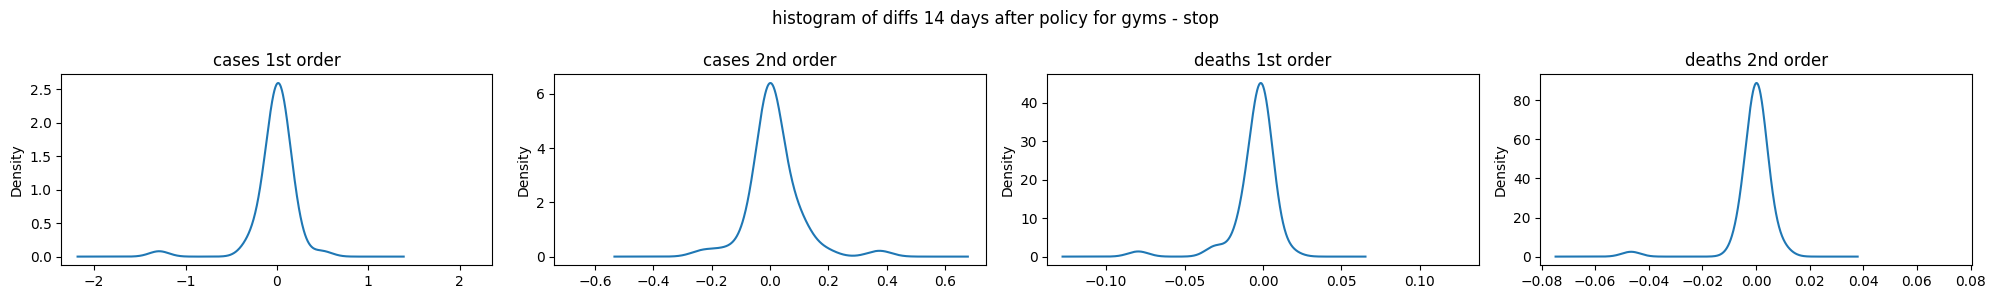

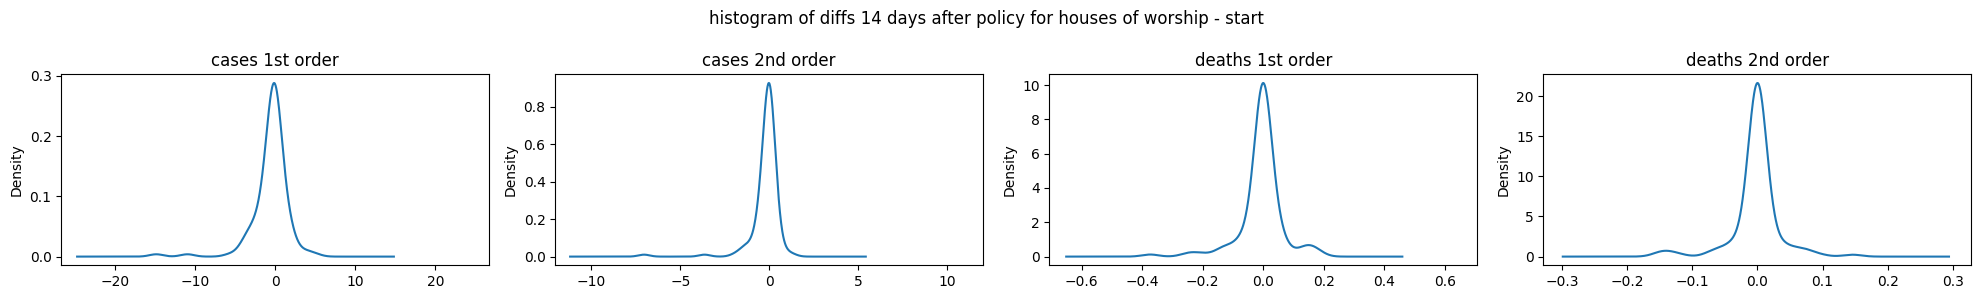

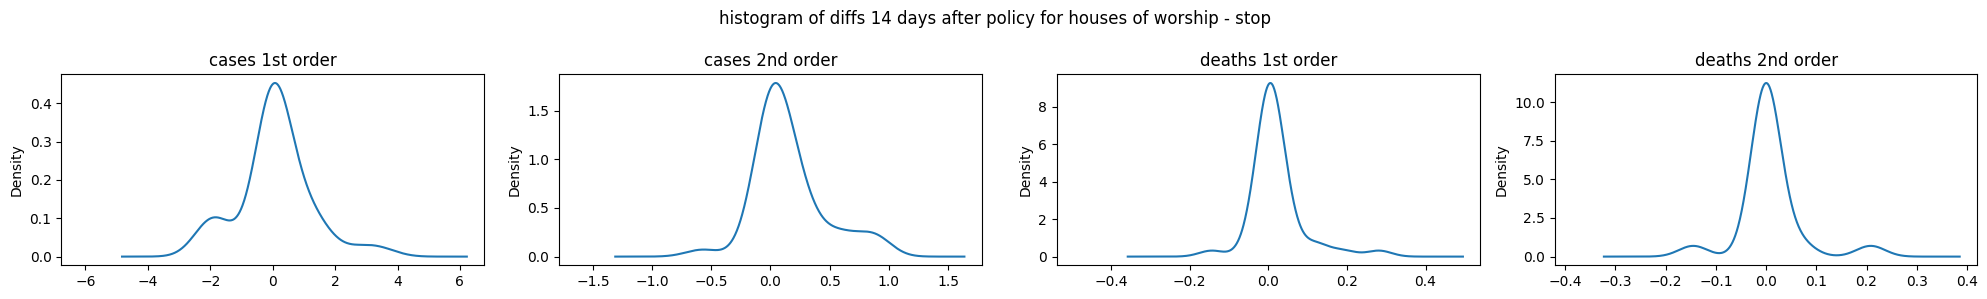

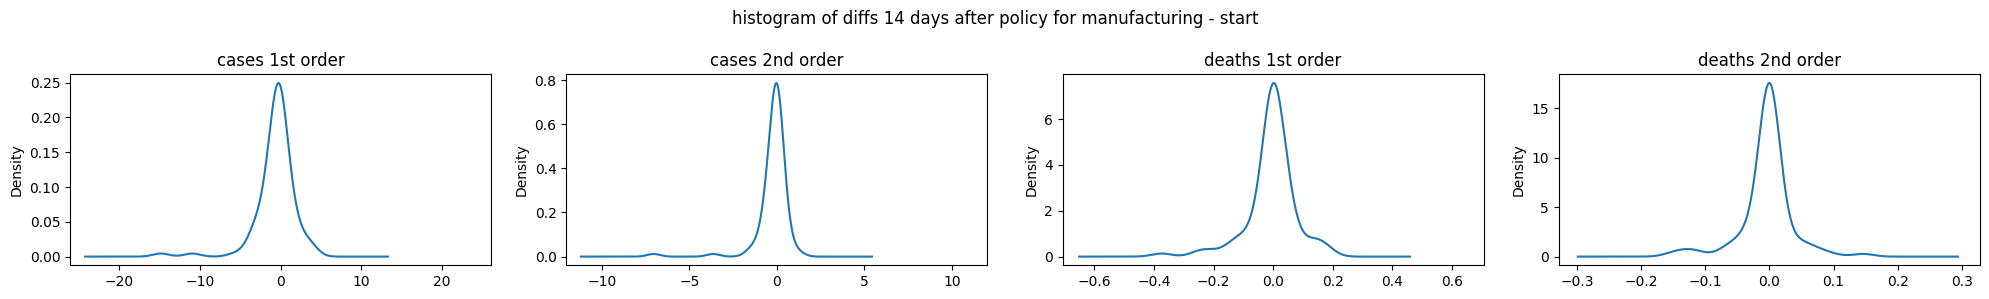

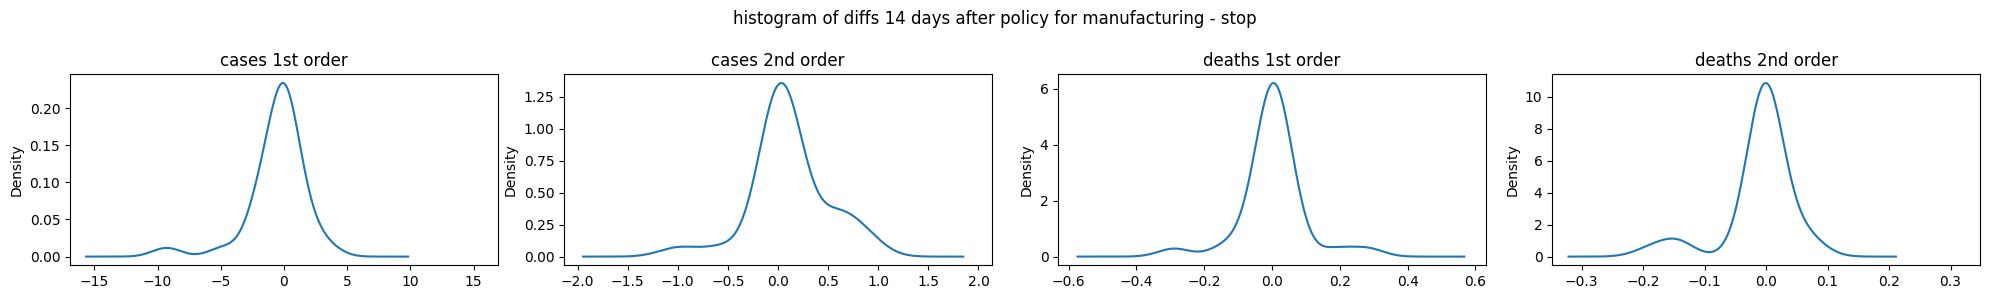

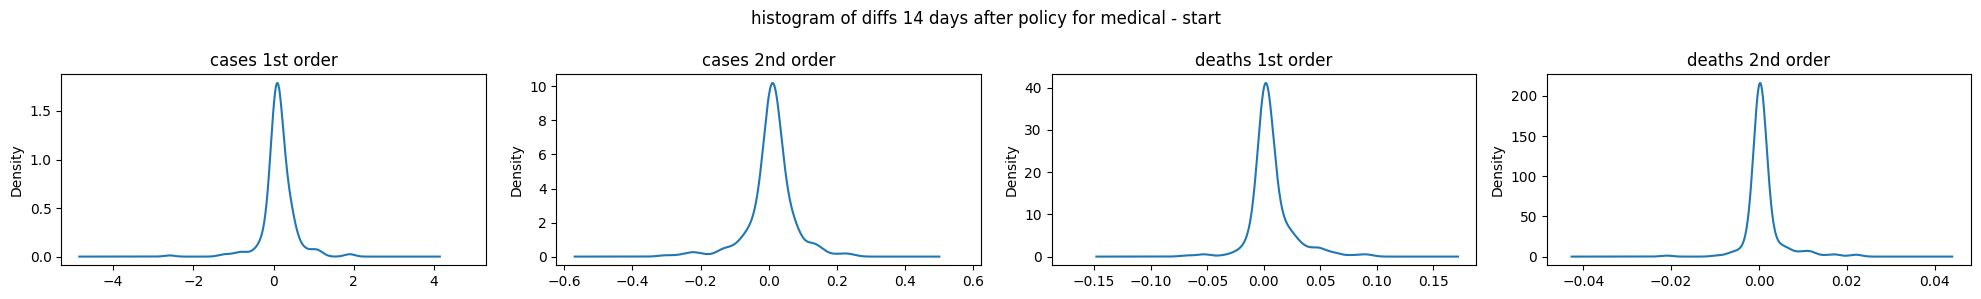

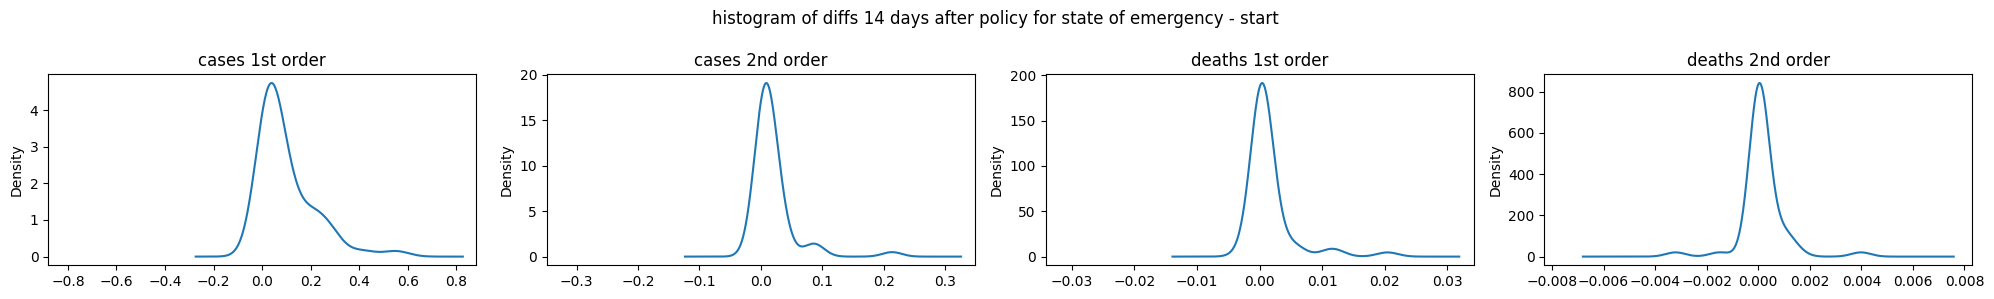

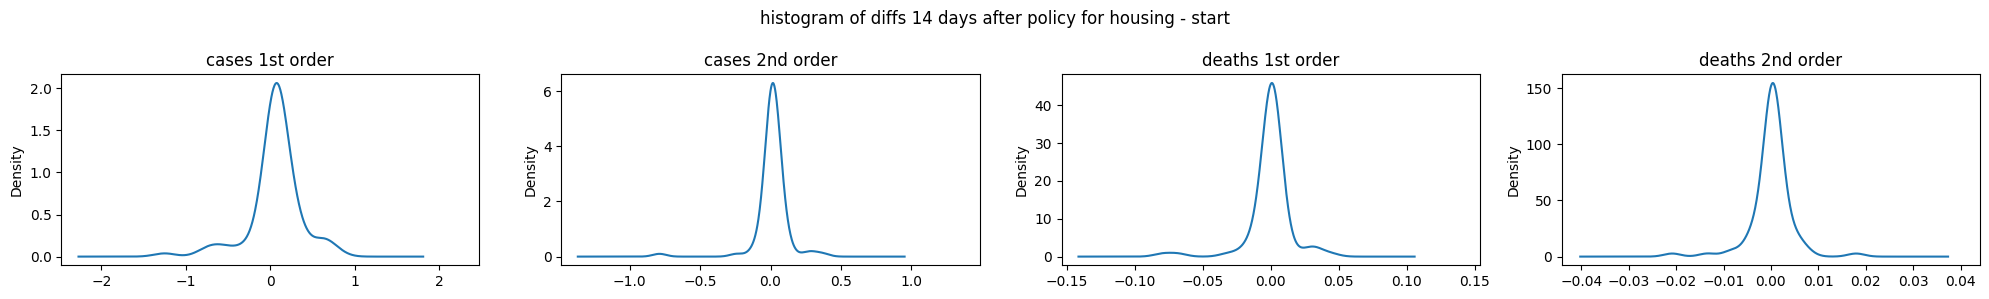

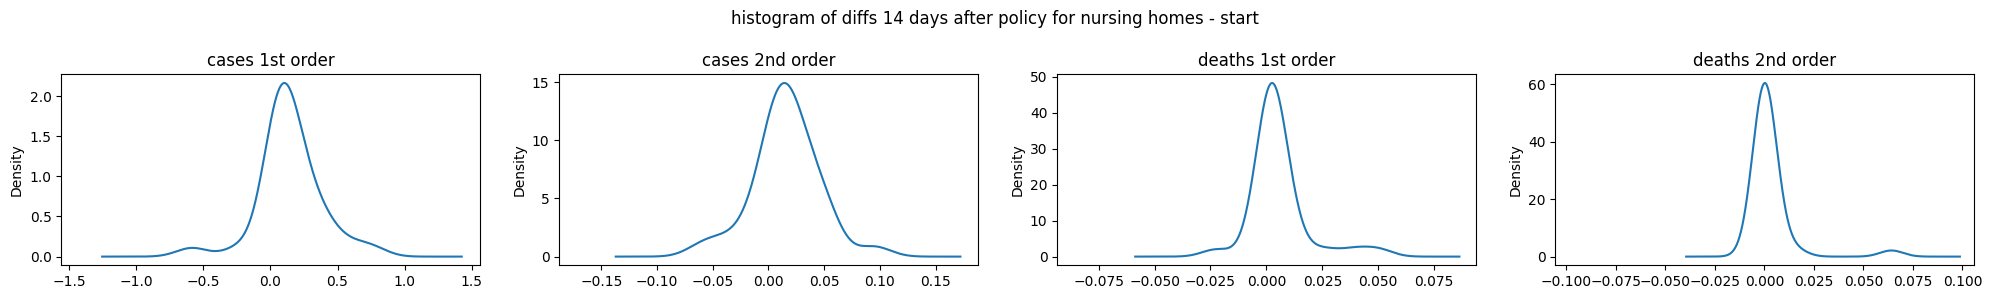

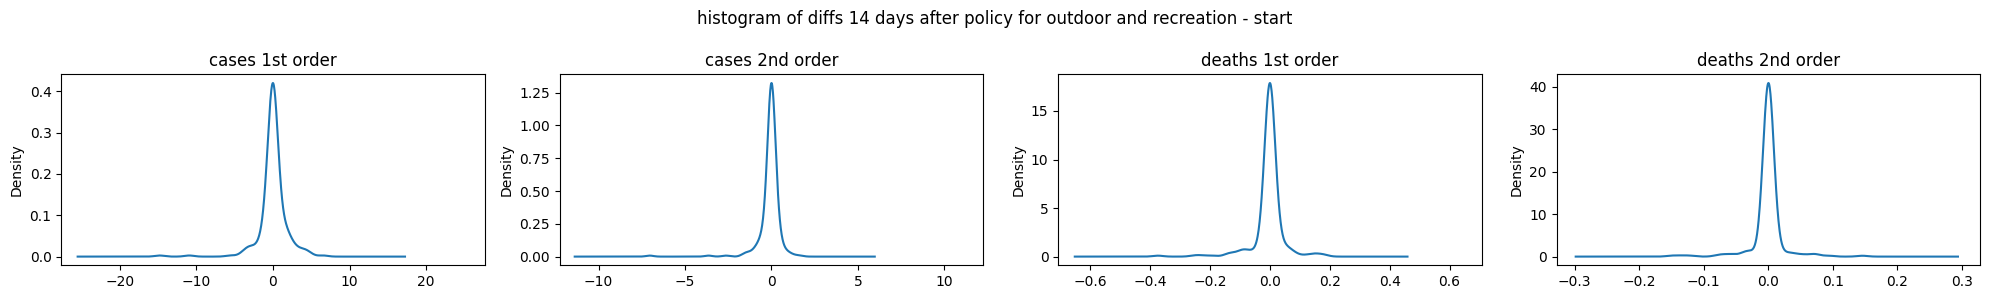

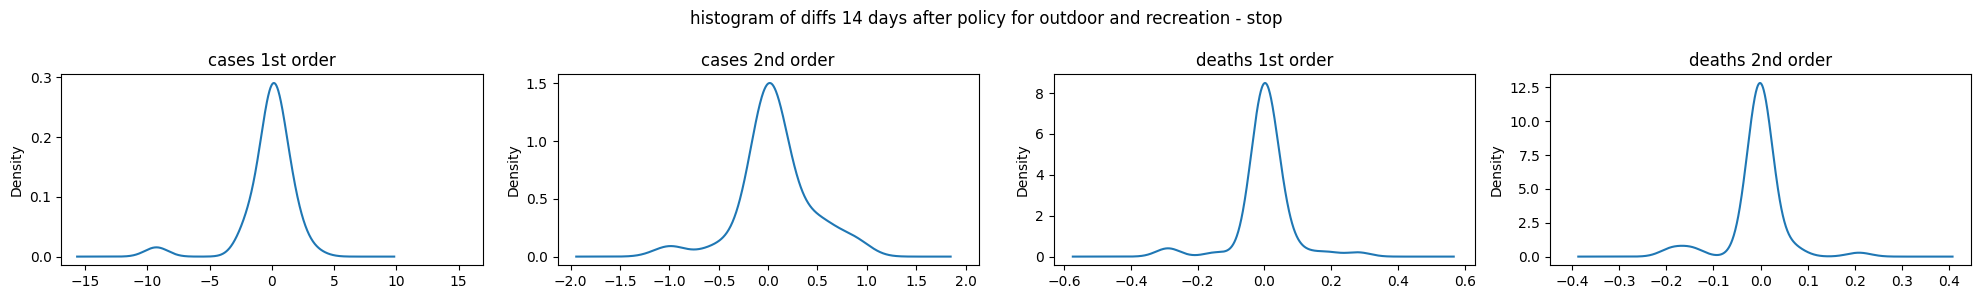

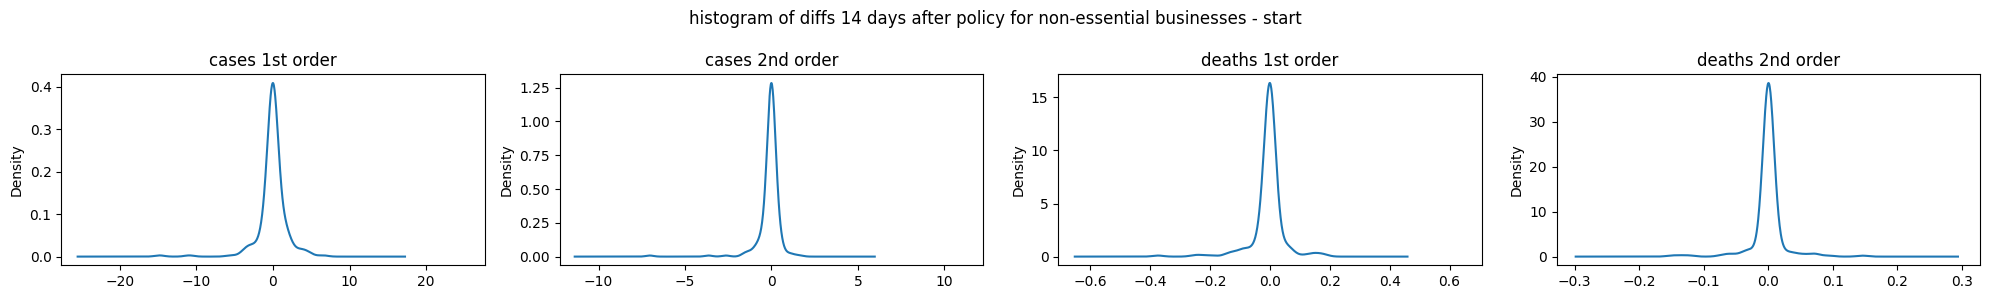

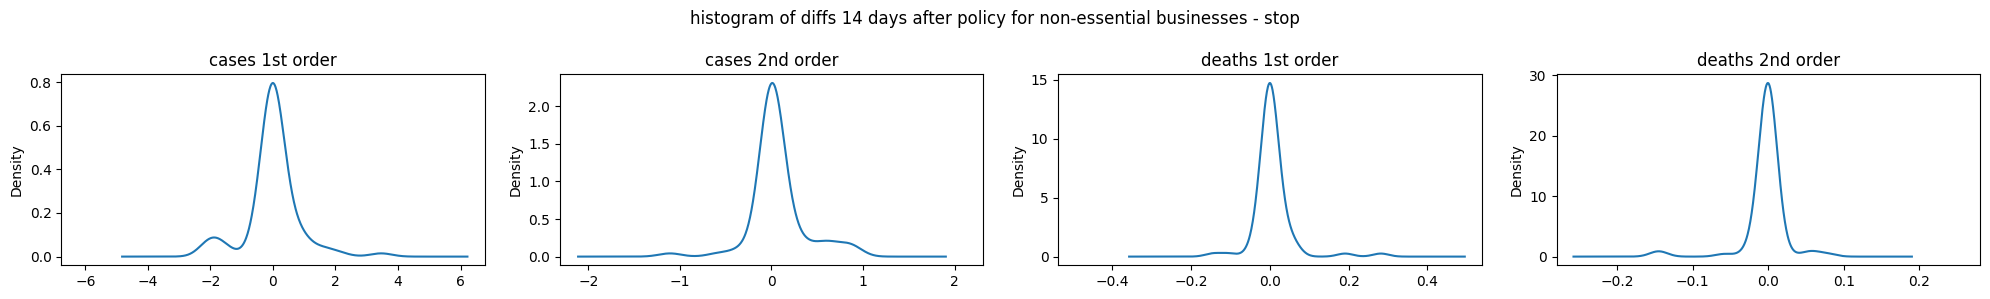

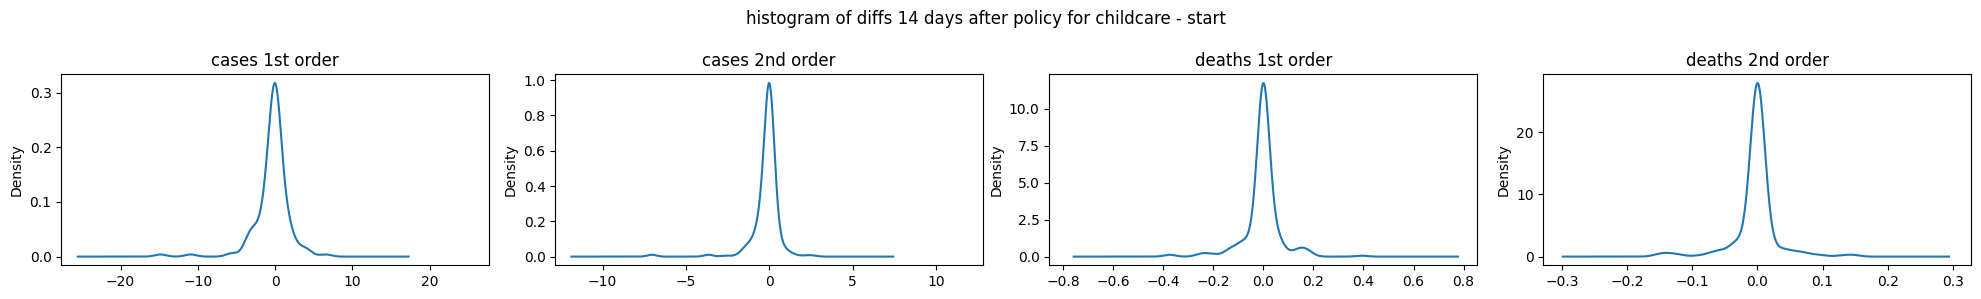

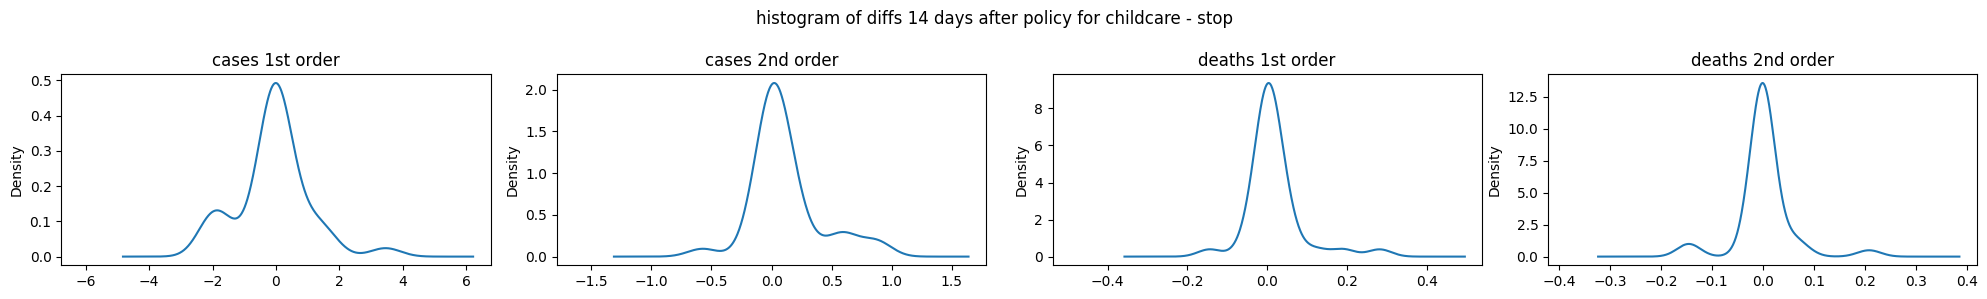

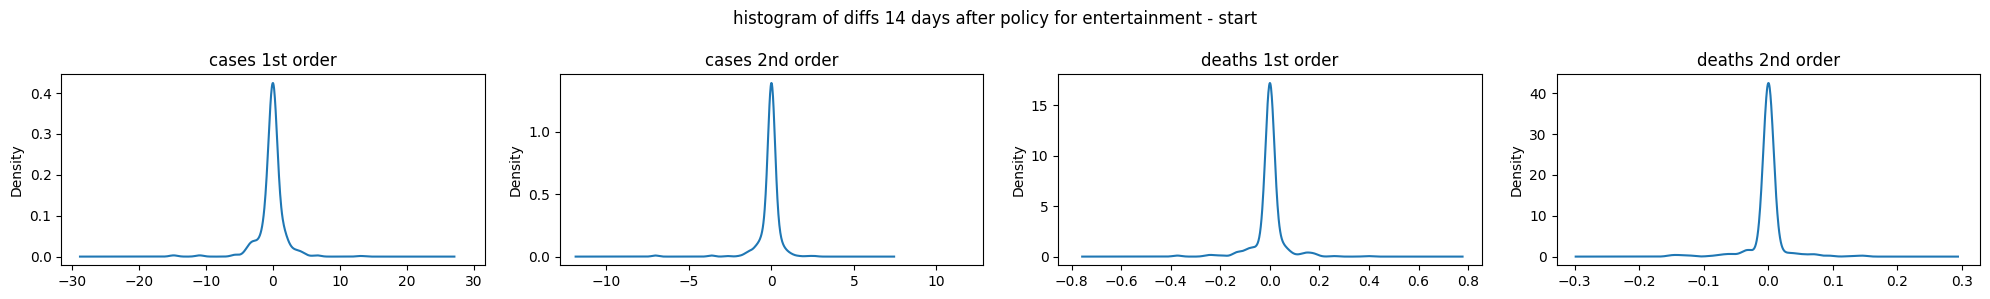

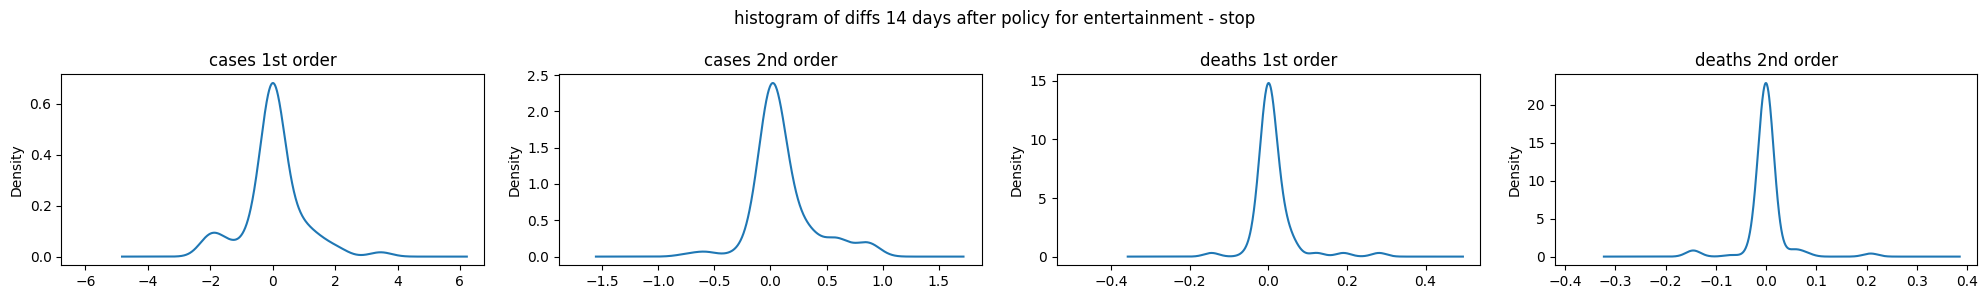

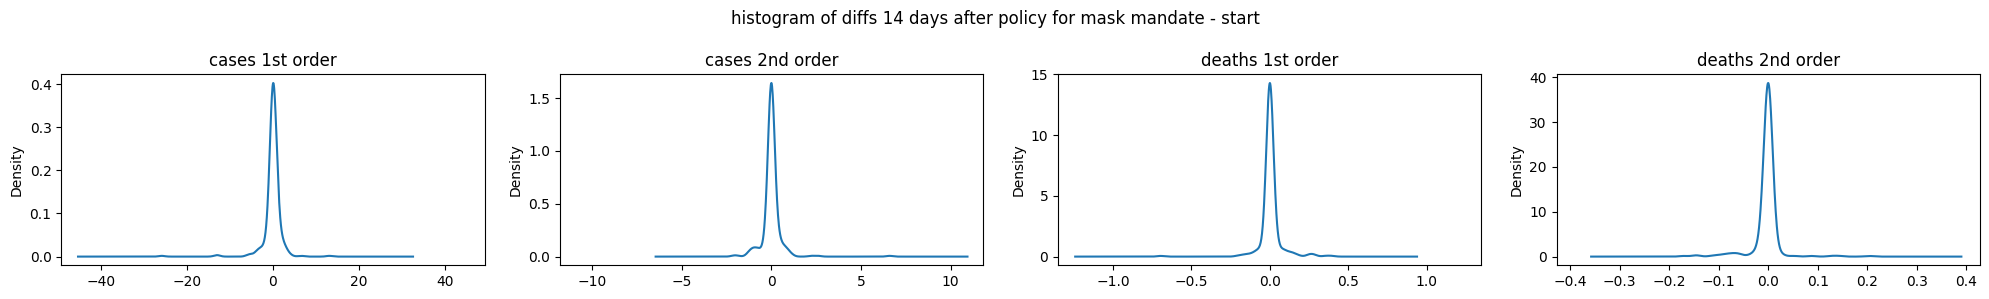

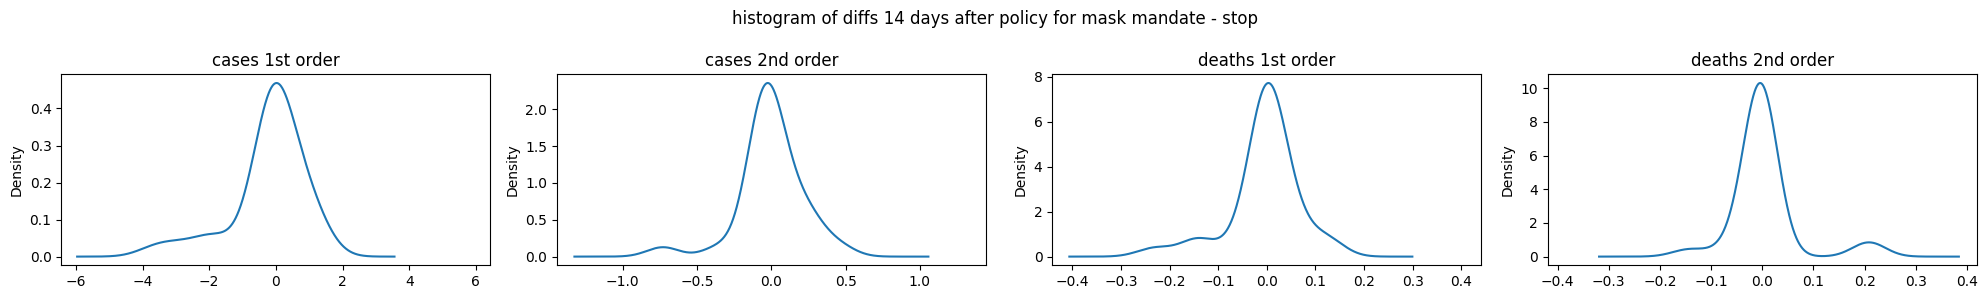

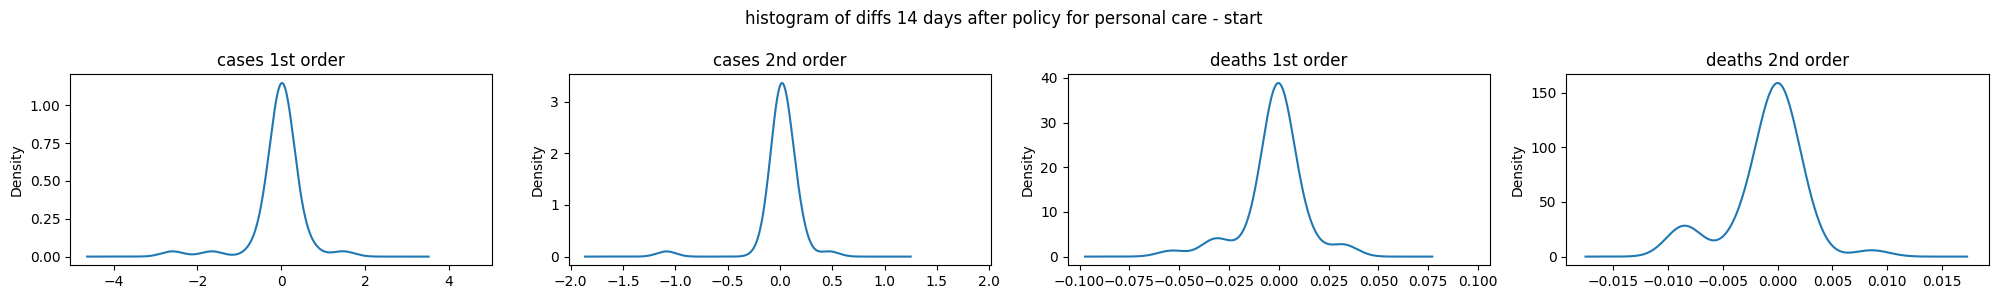

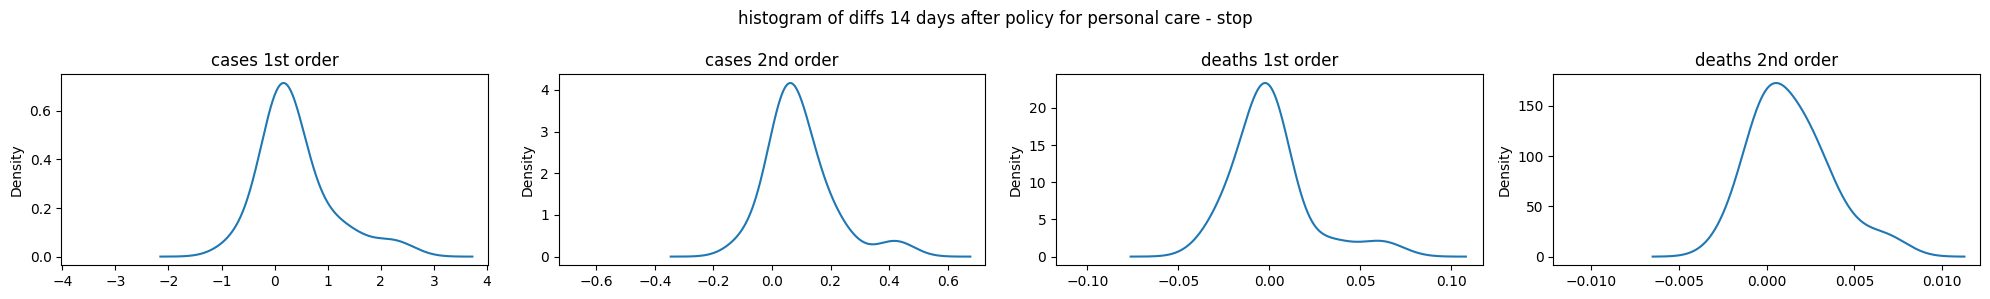

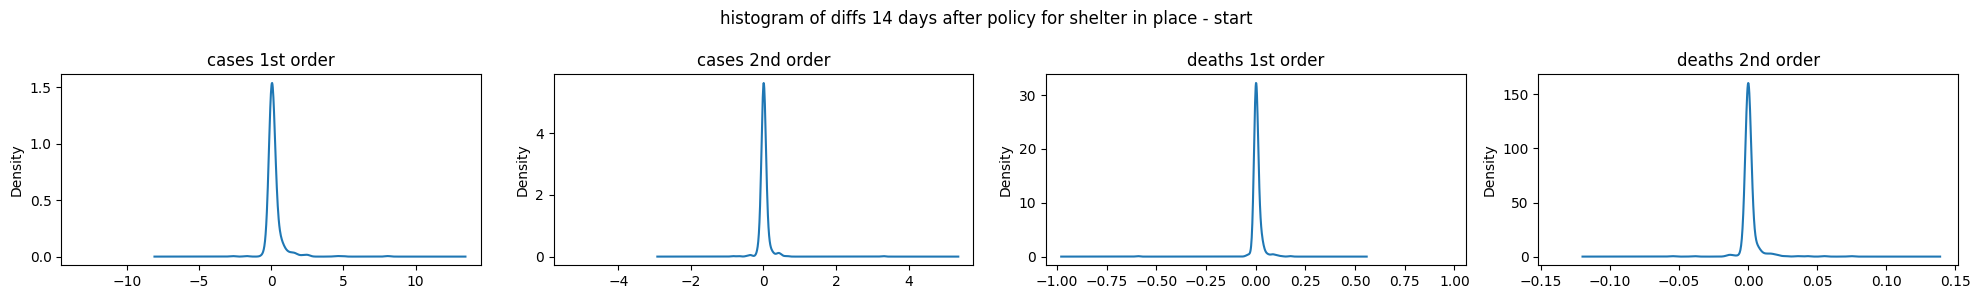

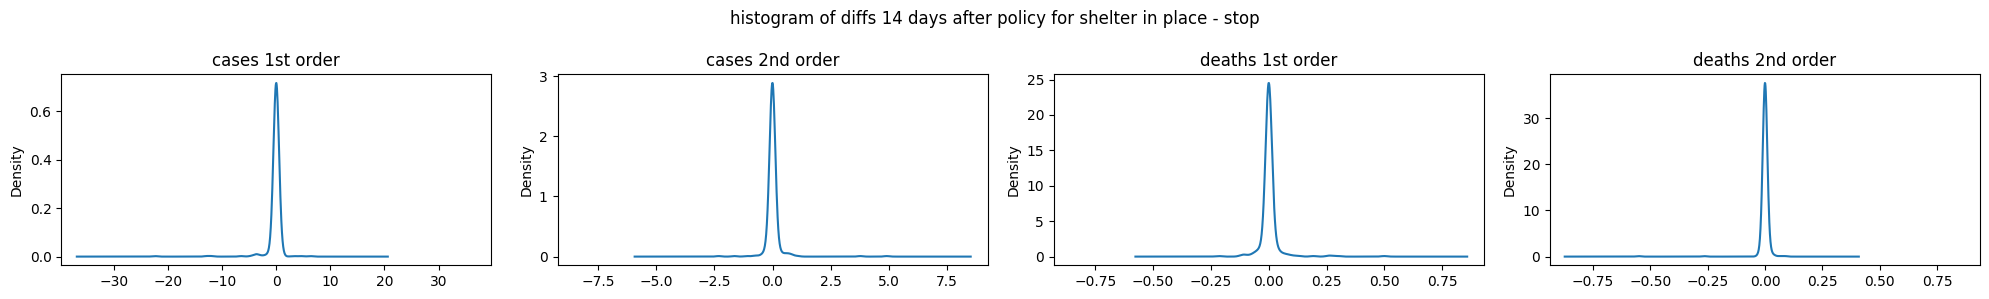

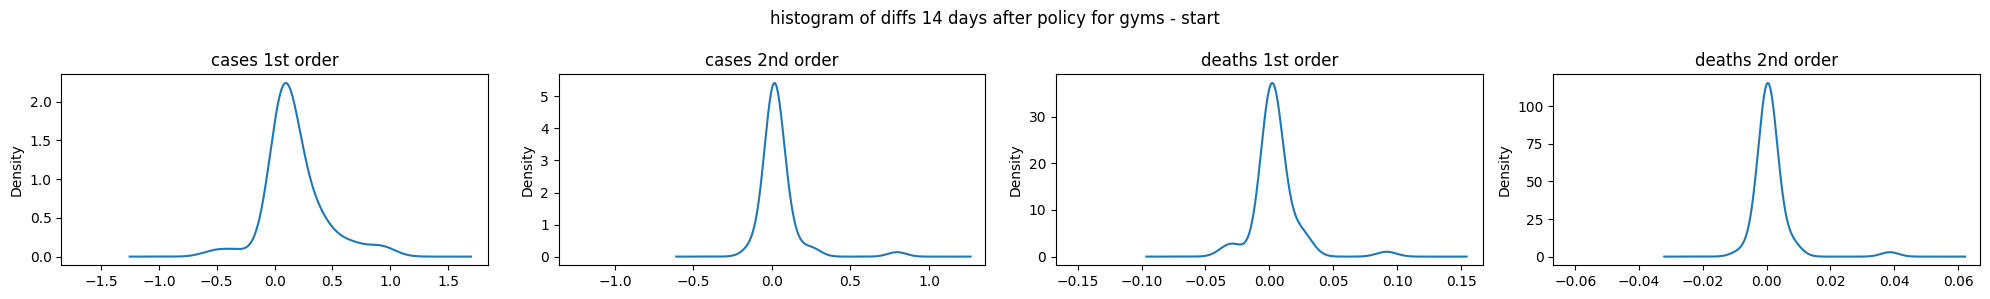

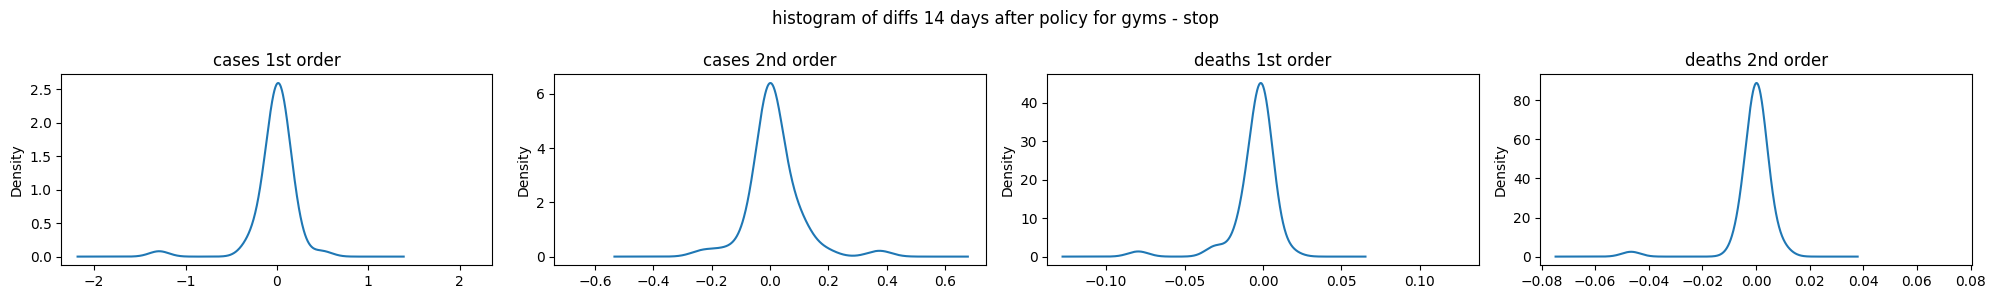

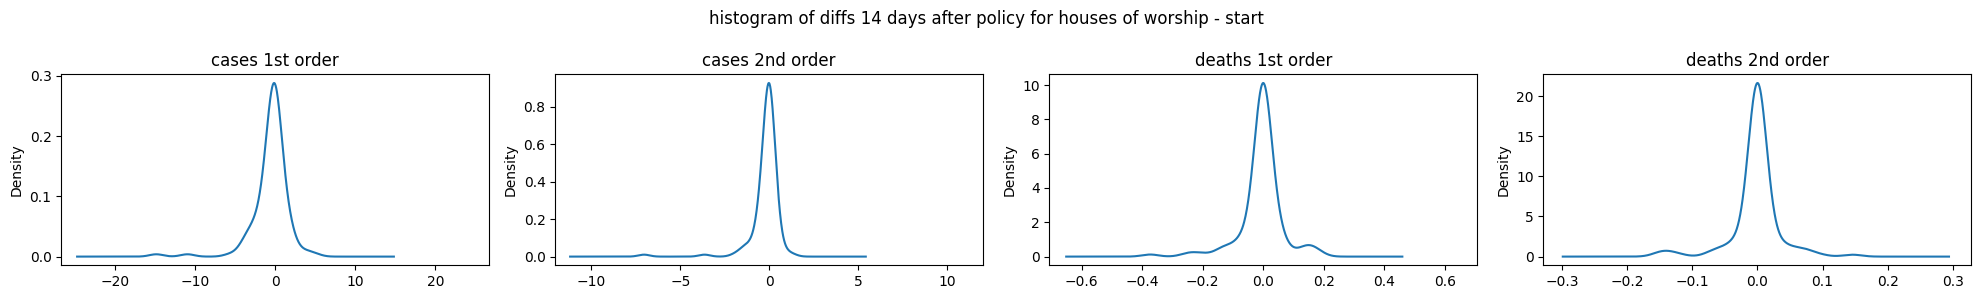

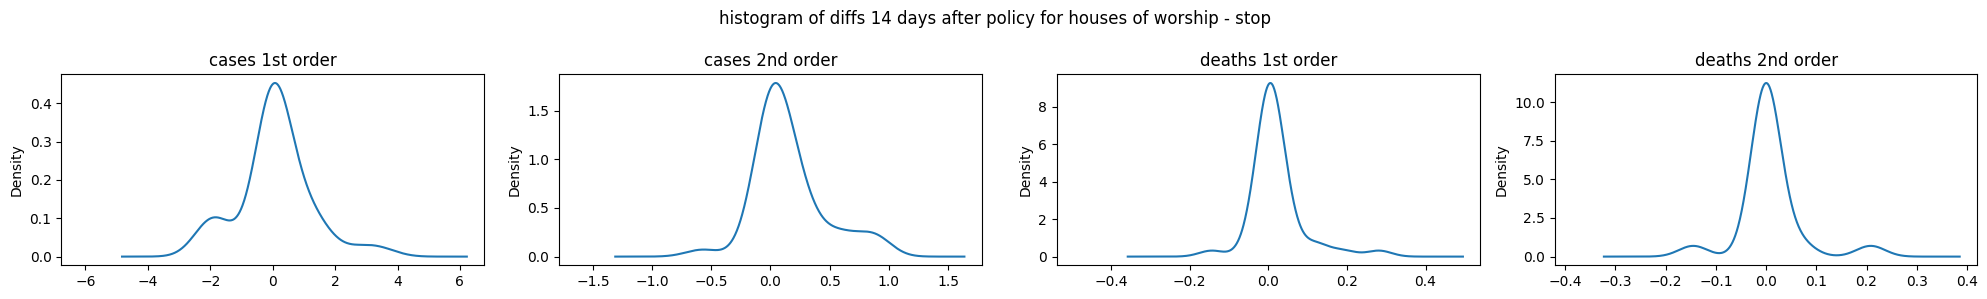

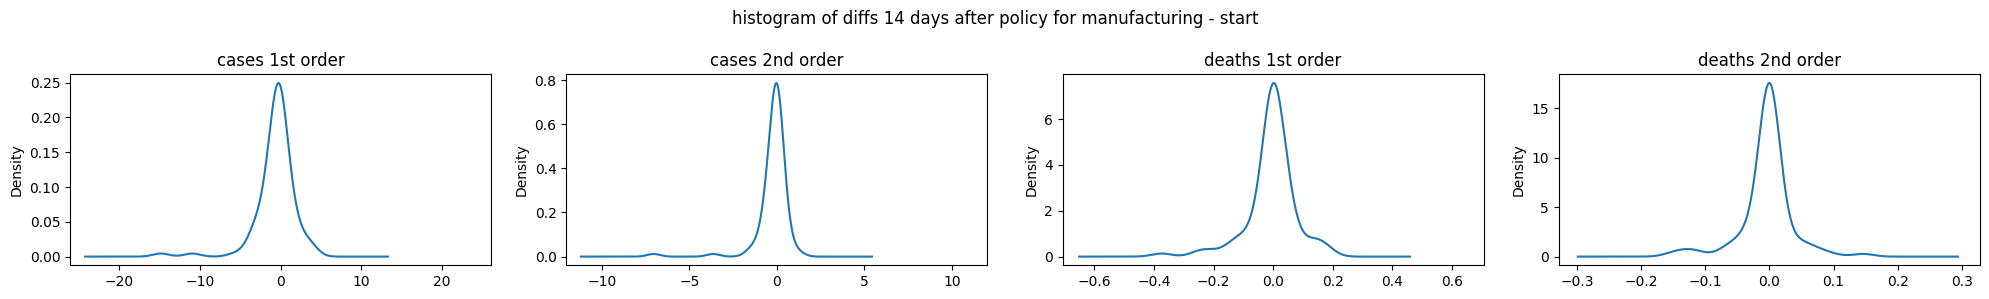

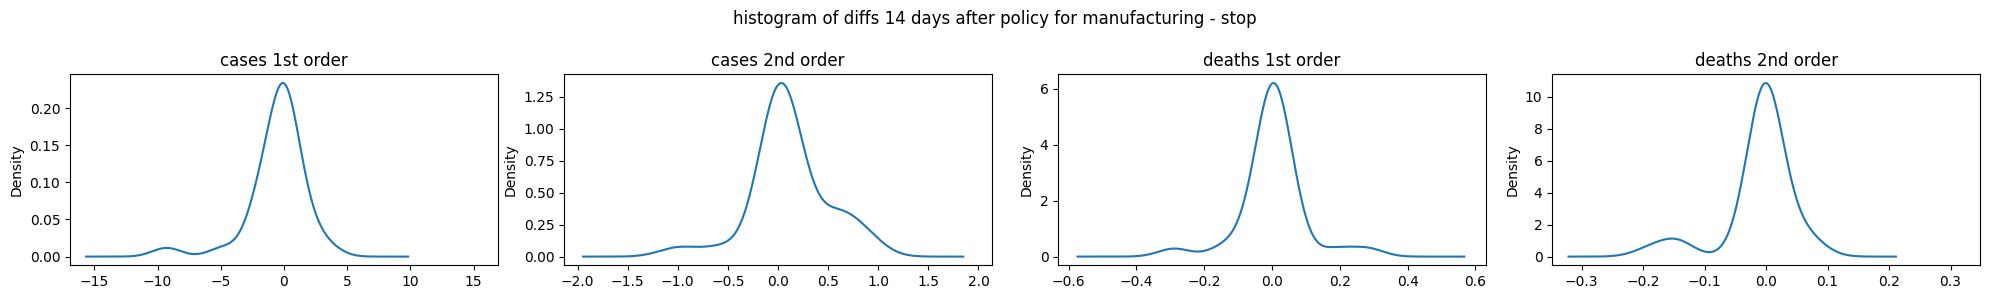

In [5]:
polices = [e.split(' - ')[0] for e in list(raws.keys())]


ncols = 4
nrows = (len(polices) * 2)

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=[ncols*4, nrows*3])
for i, policy in enumerate(polices):
    for start_stop in ['start', 'stop']:
        if policy + ' - ' + start_stop not in raws:
            continue
        fig, axes = plt.subplots(ncols=4, figsize=[20, 3])
        raws[policy + " - " + start_stop]['case_order_1'].plot.kde(ax=axes[0])
        axes[0].set_title("cases 1st order")
        raws[policy + " - " + start_stop]['case_order_2'].plot.kde(ax=axes[1])
        axes[1].set_title("cases 2nd order")
        raws[policy + " - " + start_stop]['death_order_1'].plot.kde(ax=axes[2])
        axes[2].set_title("deaths 1st order")
        raws[policy + " - " + start_stop]['death_order_2'].plot.kde(ax=axes[3])
        axes[3].set_title("deaths 2nd order")
        for ax in axes:
            xabs_max = abs(max(ax.get_xlim(), key=abs))
            ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
    
        plt.suptitle("histogram of diffs 14 days after policy for " + policy + " - " + start_stop)
        fig.tight_layout()
    



Most of the histograms are centered around zero. Some histograms show a skew towards positive or negative values, for example:

- outdoor recreation - stop (2nd order cases)
- childcare - stop (1st order cases)
- mask mandate - stop (1st order deaths)

Additionally, some histograms exhibit a multimodal distribution, such as:

- gyms - stop (2nd order cases)
- houses of worship - stop (2nd order cases

## 2. Significance test at 14 days


Next, I constructed 95% confidence intervals (CIs) using a two-sided t-test and visualized the margin of error. Red indicates that the mean difference is significantly above zero, while green indicates that the mean difference is significantly below zero

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/diffs.py:226: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = delta_stats.loc[index][8]


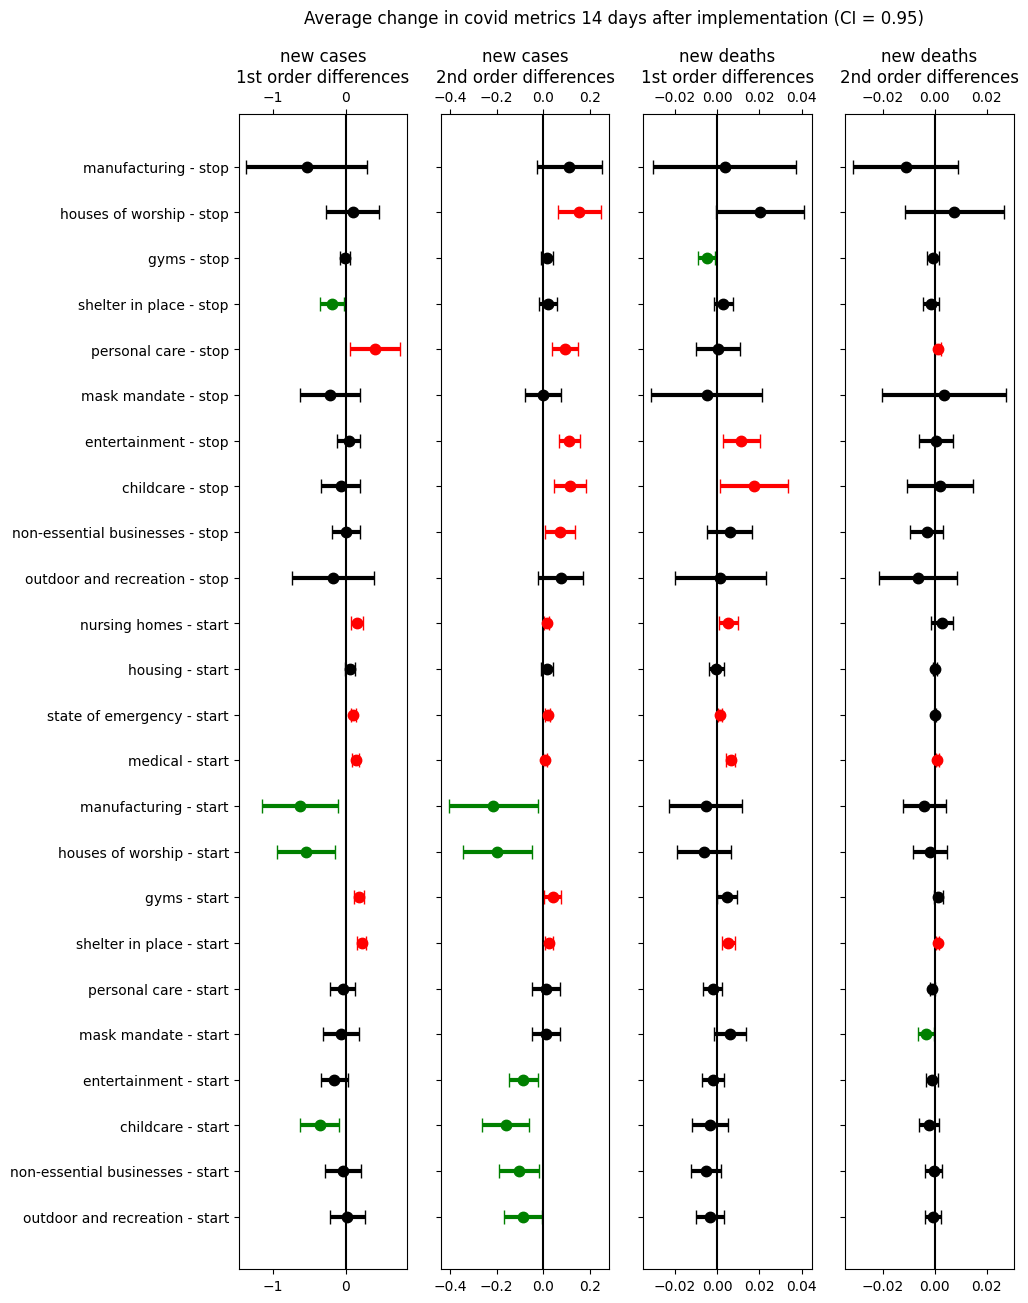

In [6]:
fig = deltas.plot_delta_stats(delta_stats,
                 save_figure=True,
                 interval="0.95",
                 filename="./figures/average_changes_in_covid_metrics_14_days_95CI.png");

After 14 days, there appear to be some significant changes. Starting policies related to manufacturing, houses of worship, and childcare had a significant decrease in both 1st order and 2nd order case differences. Starting policies related to non-essential businesses and outdoor and recreation only showed a significant improvement in 2nd order differences.

However, the majority of these policies seem to be correlated with an increase in cases or deaths, such as personal care - stop, entertainment - stop, nursing homes - start, and state of emergency - start.

These results shoudl be taken with caution for a few reasons:
- **Normality Assumption**: T-tests assume that the data follows a normal distribution. Several of the histograms shown above do not meeet this assumption, which can make the t-tests unreliable.
- **Bimodal Distributions**: For instance, there is a significant increase in the 2nd order differences in new cases for `childcare - stop`. However, the histogram shows an almost bimodal distribution. This deviation from normality suggests that the results shoud be interpreted cuatiously.
- **Correlation vs. Causation**: It is important to note that these results show correlations, not causations. Further analysis would be needed to determine any causal relationship.


## 3. Varying measure period


The discussions above focused on analyzing the 1st and 2nd order differences 14 days after the policy started. Let's now examine what happens when we change that lag period.

The script at the top of the notebook conducts 1st and 2nd order differencing for all counties between 4 and 30 days. First, we collect all the results into a single dataset and calculate the statistics for this dataset. Then, we visualize the results

In [7]:
dfs = []

for e in os.listdir("./data/diffs/"):
    lag = int(e.split('_')[0])
    df = pd.read_csv(os.path.join("data", "diffs", e), index_col=0)
    df['lag'] = lag
    df = df.rename(
        {f"case_{lag}_day_order_1": "case_order_1",
         f"case_{lag}_day_order_2": "case_order_2",
         f"death_{lag}_day_order_1": "death_order_1",
         f"death_{lag}_day_order_2": "death_order_2"},
        axis=1)
    dfs.append(df)

diffs_df = pd.concat(dfs)
diffs_df.head()

state policy_level        date               policy_type start_stop  \
1  Mississippi       county  2020-07-20    outdoor and recreation       stop   
3     Missouri        state  2020-06-15  non-essential businesses       stop   
5      Georgia       county  2020-04-30                 childcare       stop   
6     Missouri       county  2020-05-31             entertainment       stop   
7     Missouri        state  2021-08-31              mask mandate       stop   

      county  fips_code  case_order_1  case_order_2  death_order_1  \
1  sunflower      28133      0.238705      0.477411       0.058629   
3  statewide         29      0.509754      0.104569      -0.040369   
5     fulton      13121      0.127431      0.122647      -0.010873   
6    jackson      29095     -0.039659      0.051220      -0.006904   
7  statewide         29     -1.057083      0.653029       0.002795   

   death_order_2  lag  
1       0.238705    9  
3      -0.007241    9  
5       0.000109    9  
6       0.000000    9  
7      -0.012125    9

/tmp/ipykernel_62759/1958170131.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))


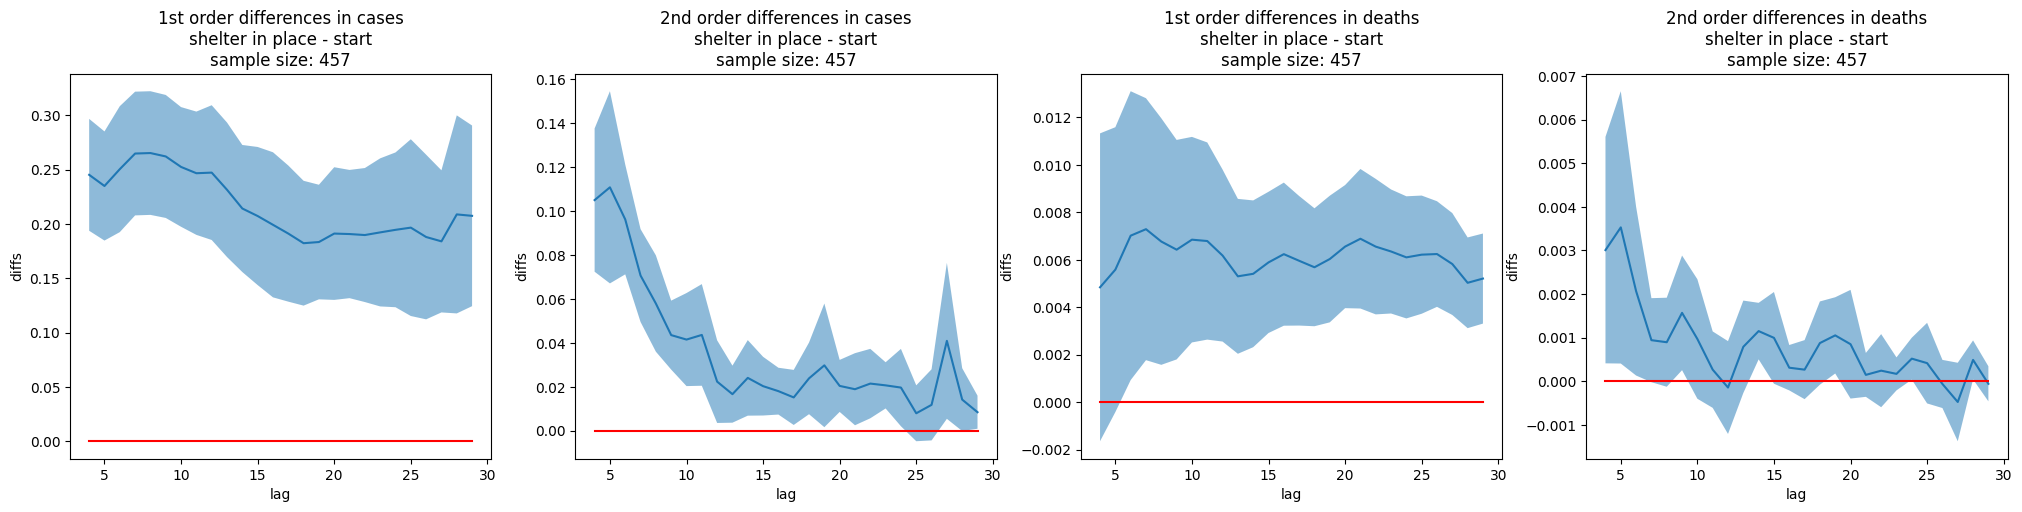

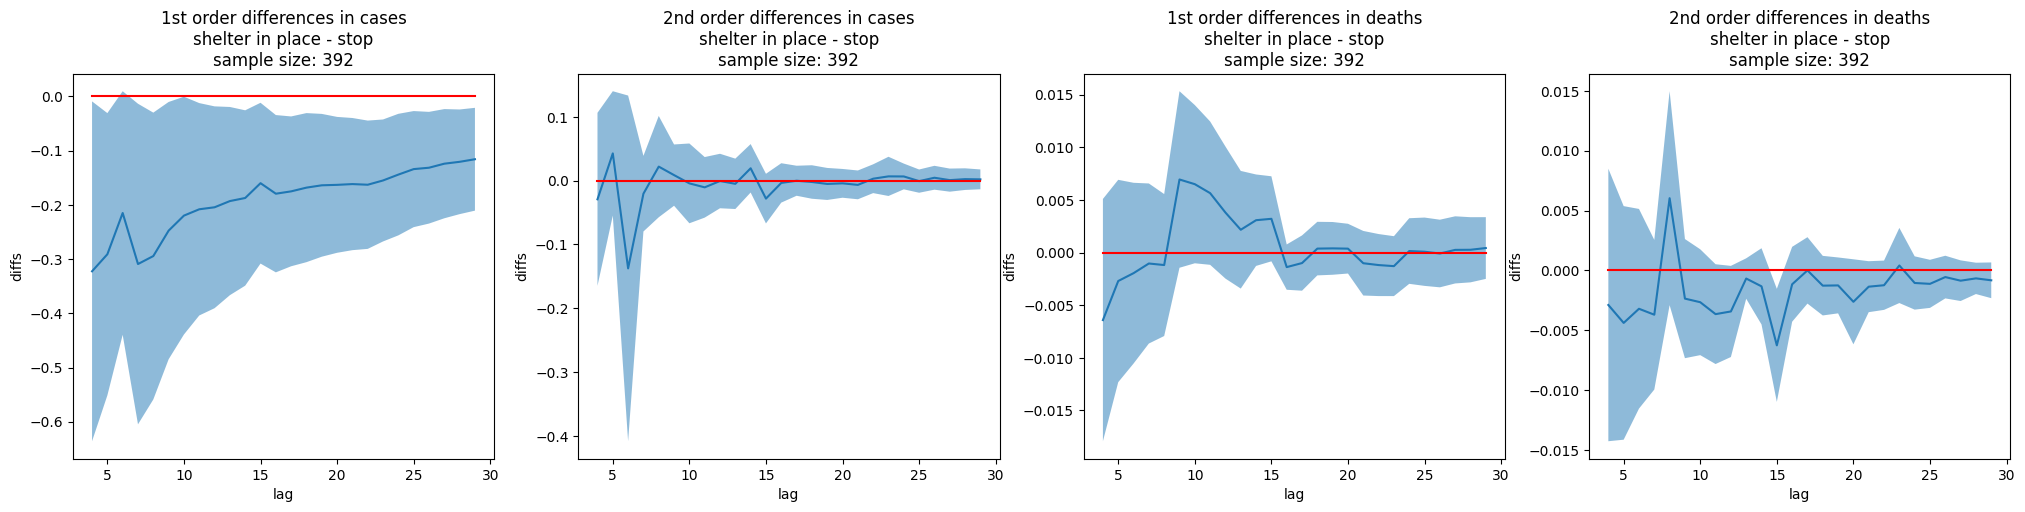

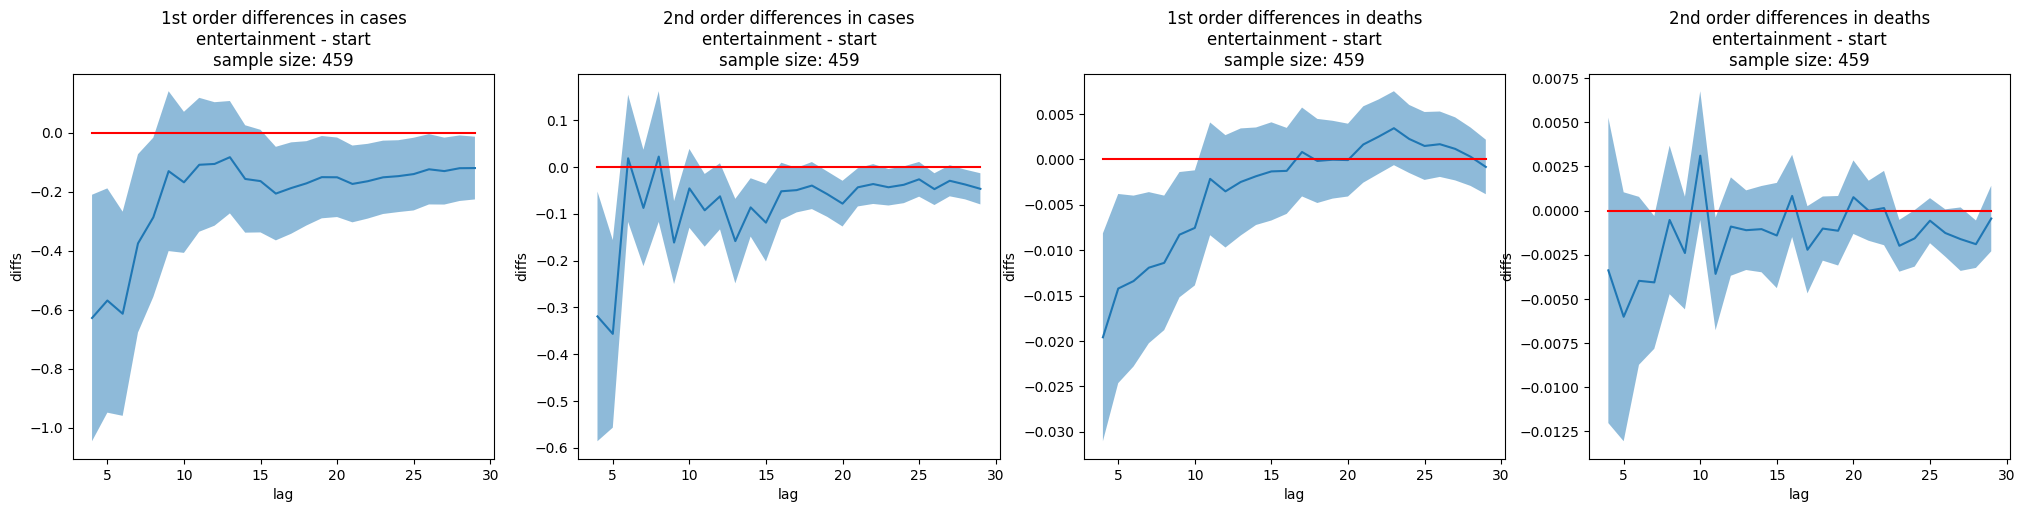

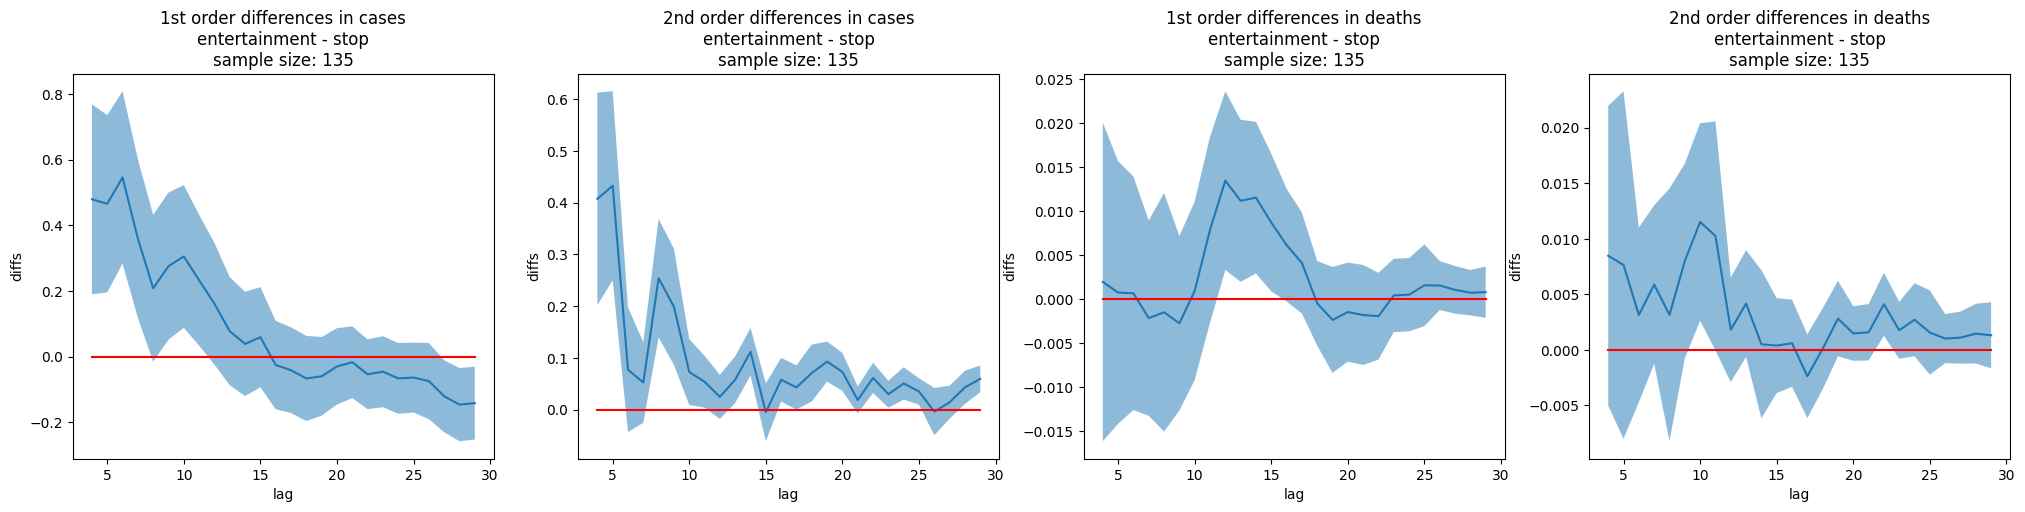

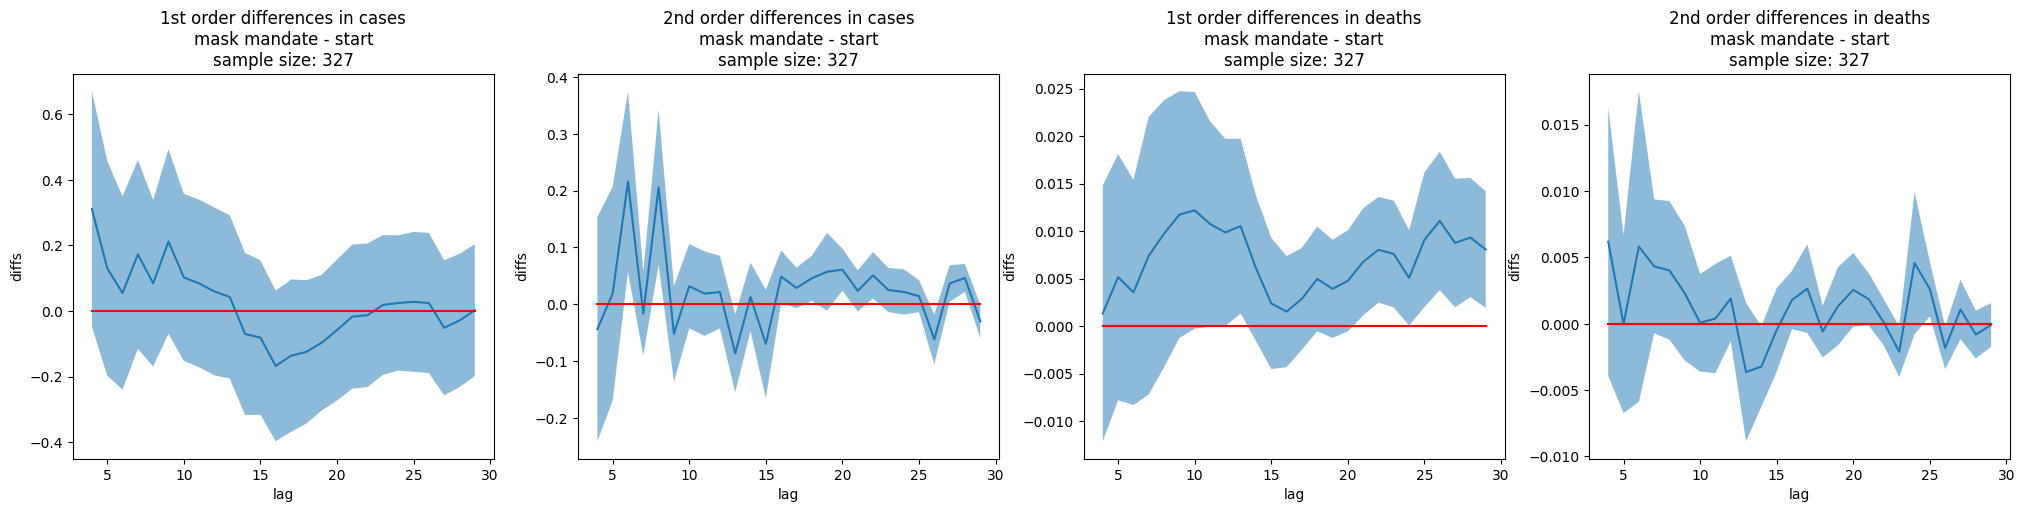

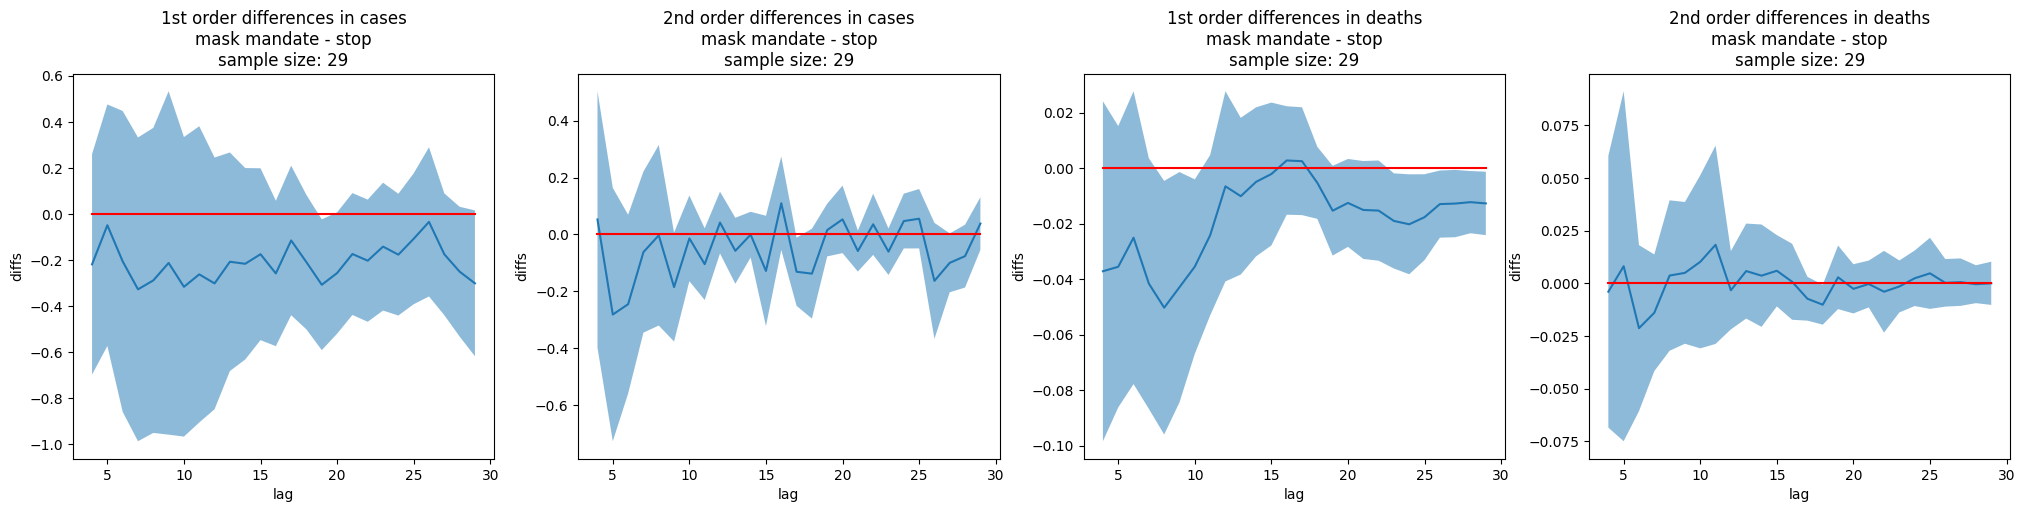

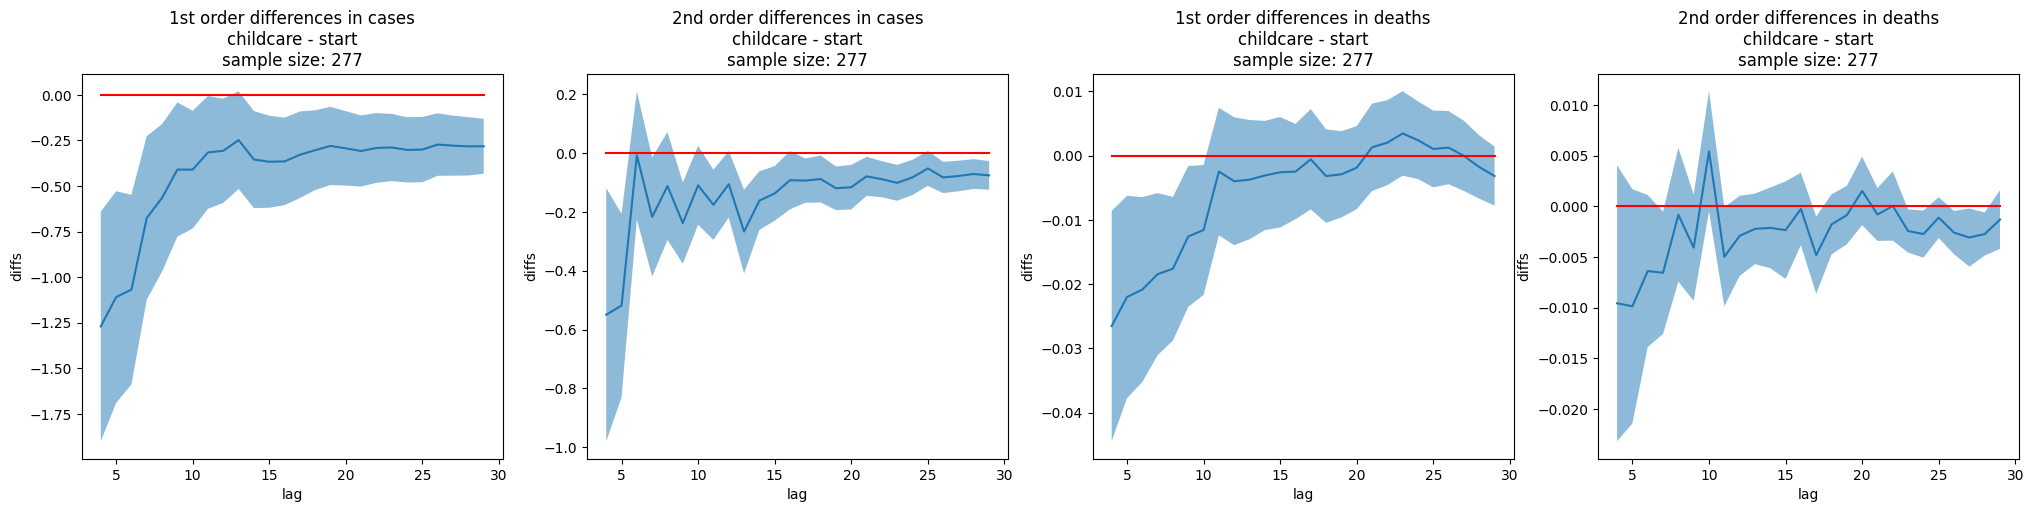

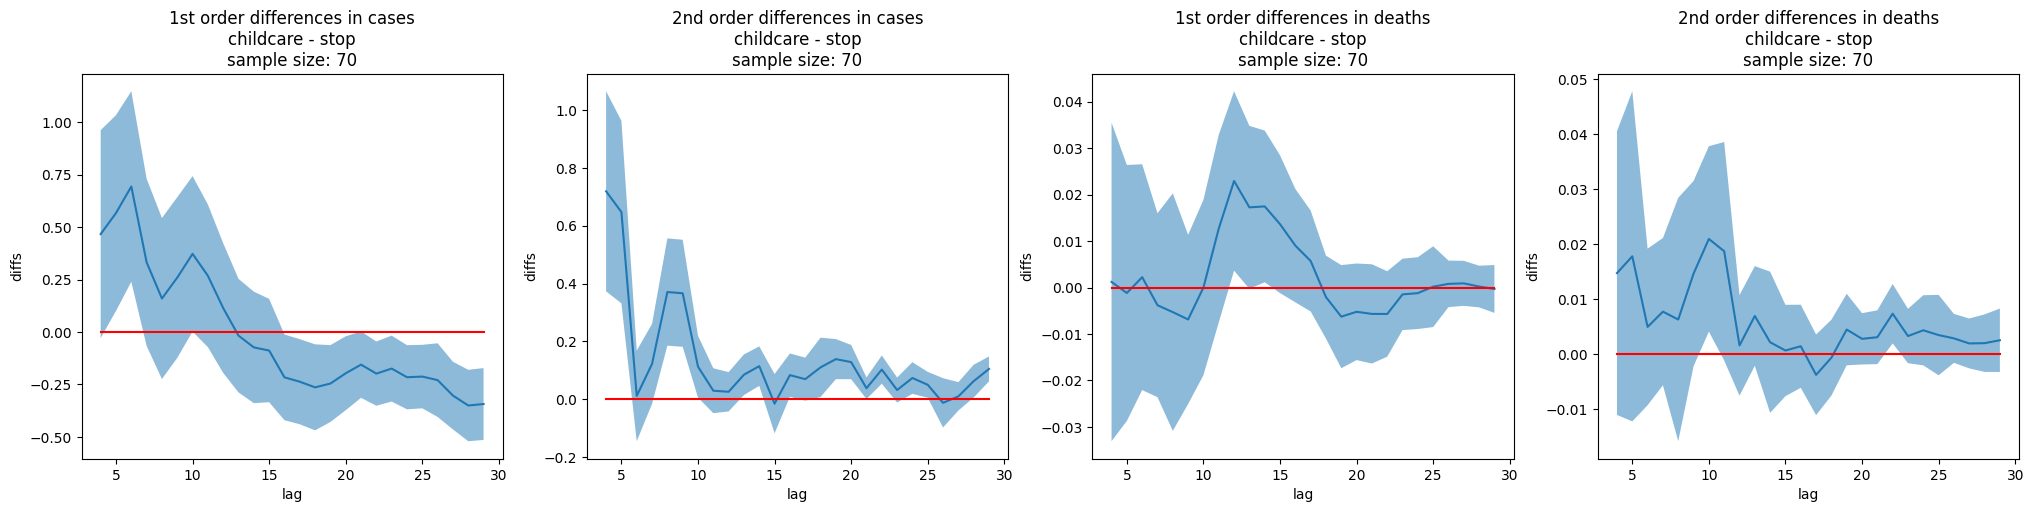

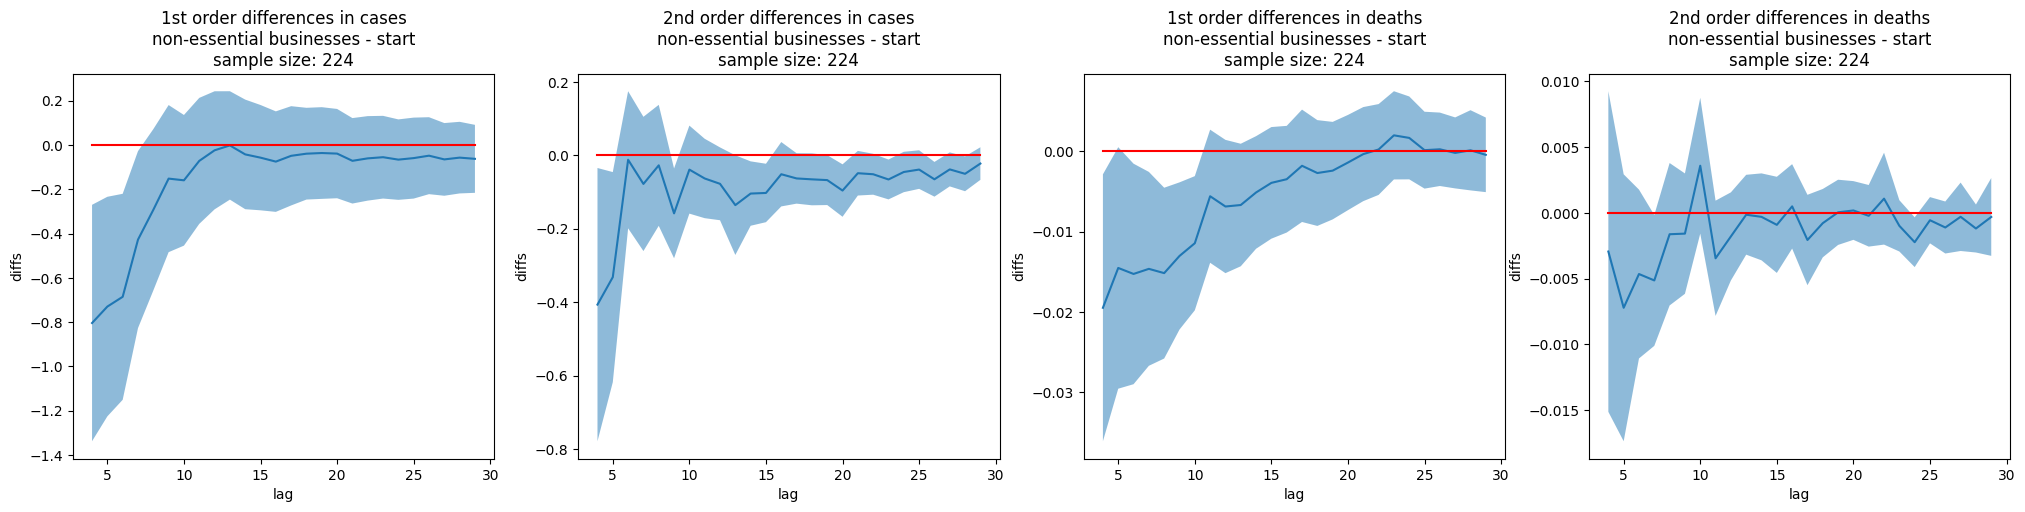

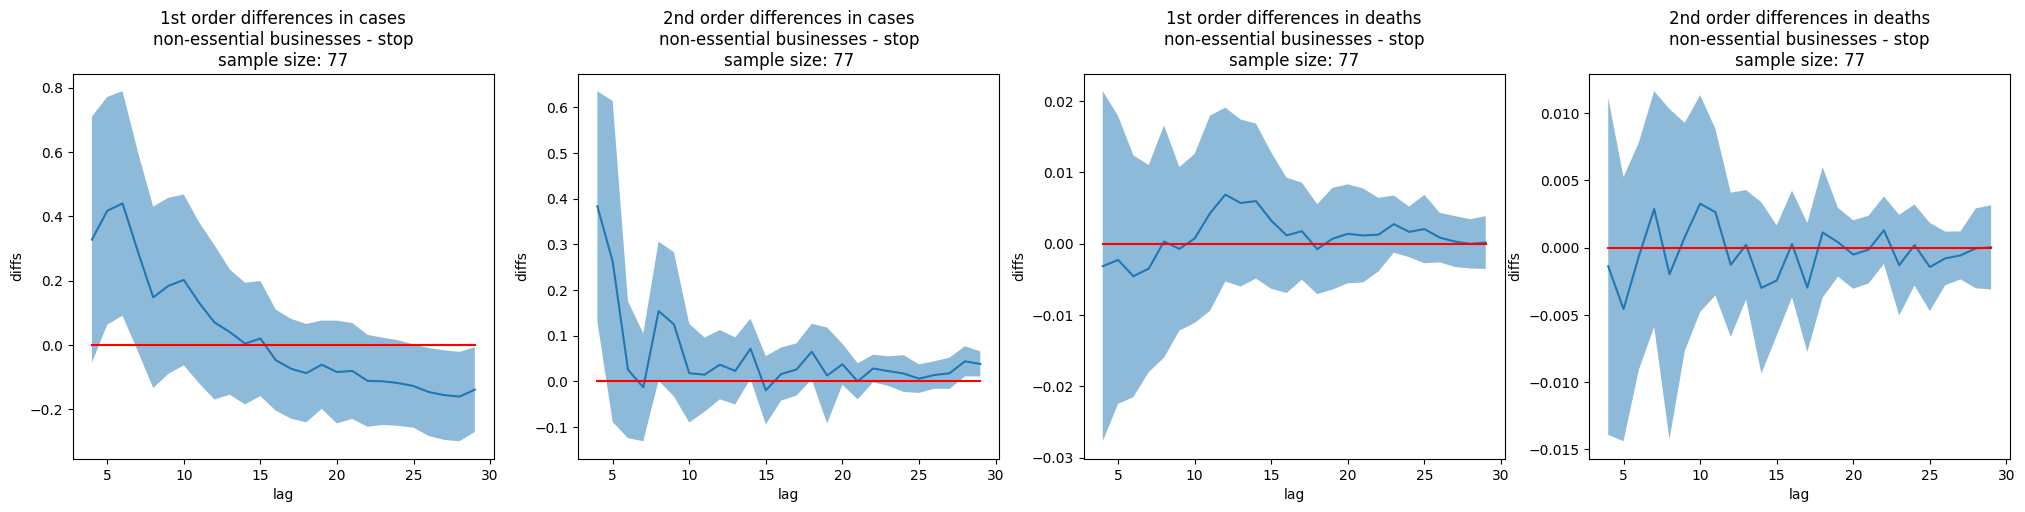

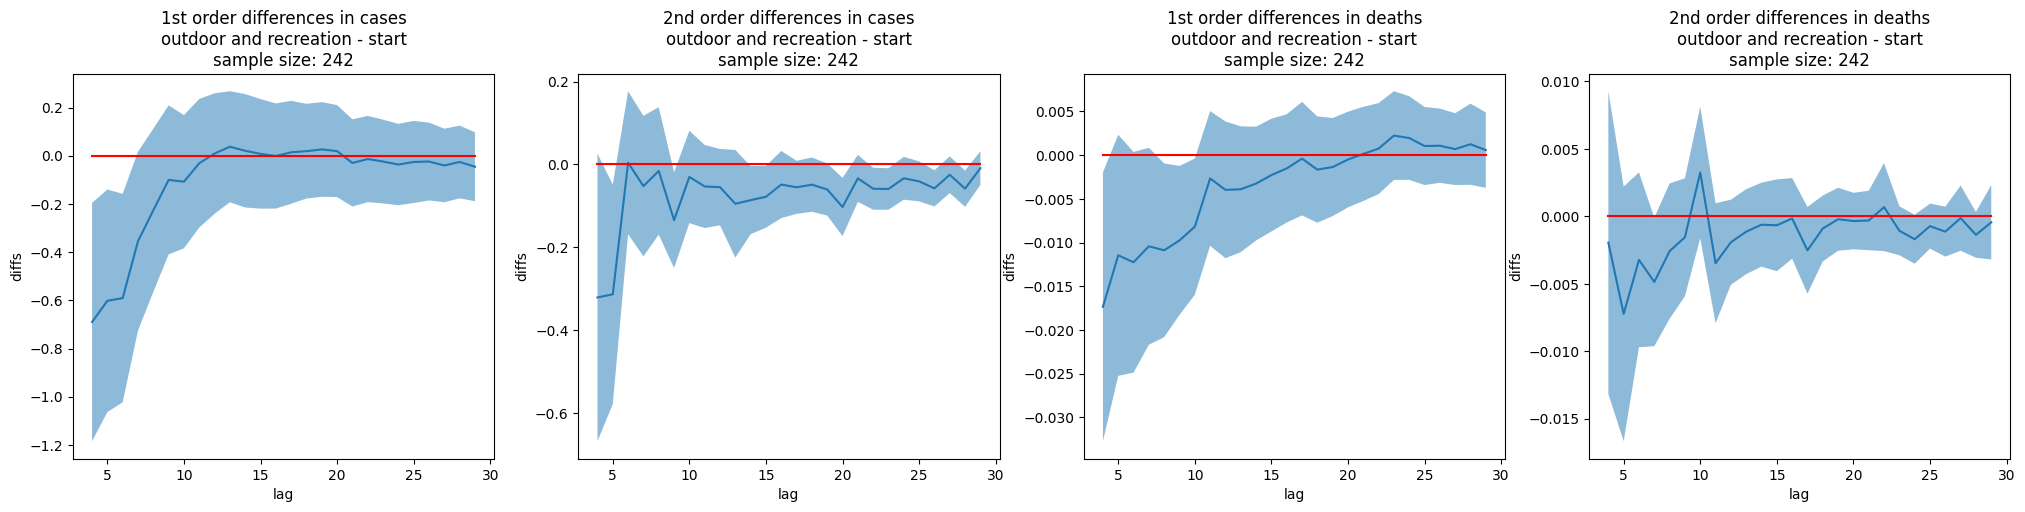

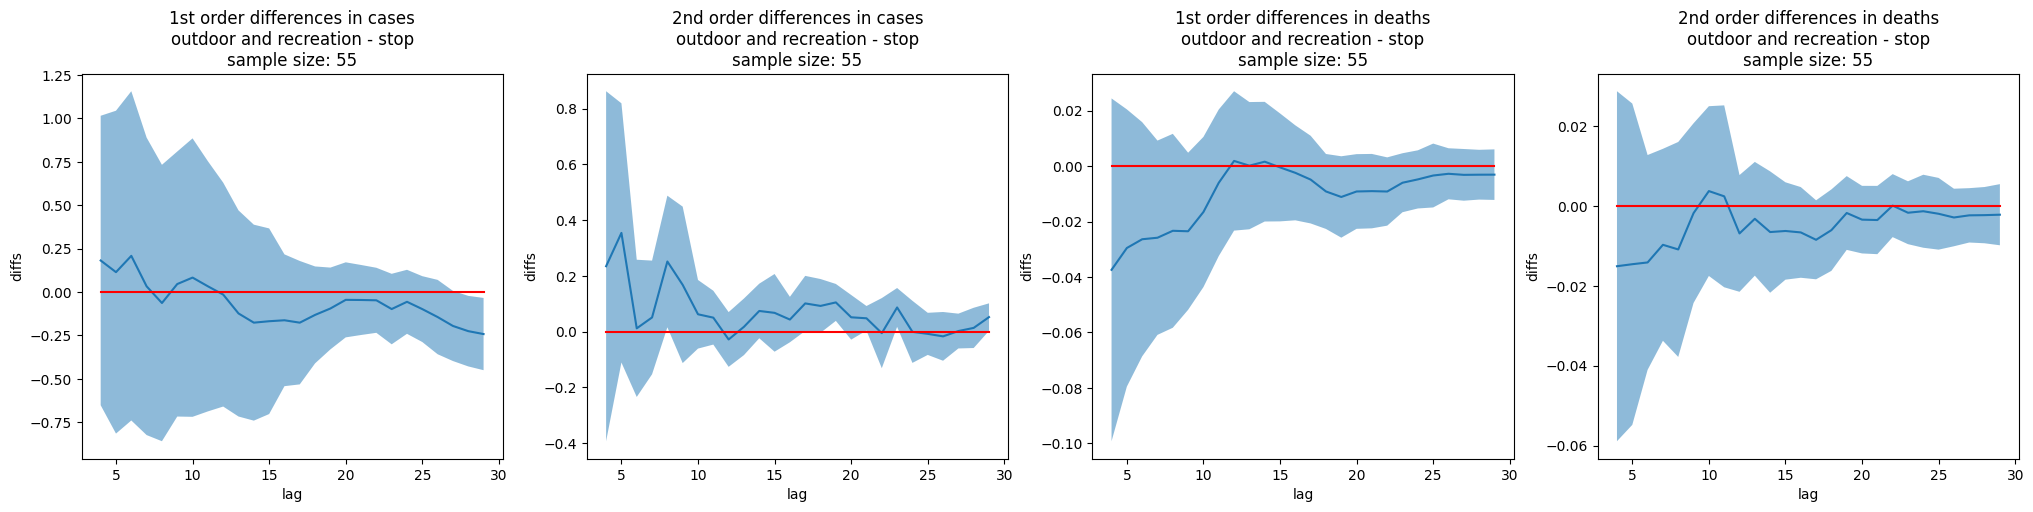

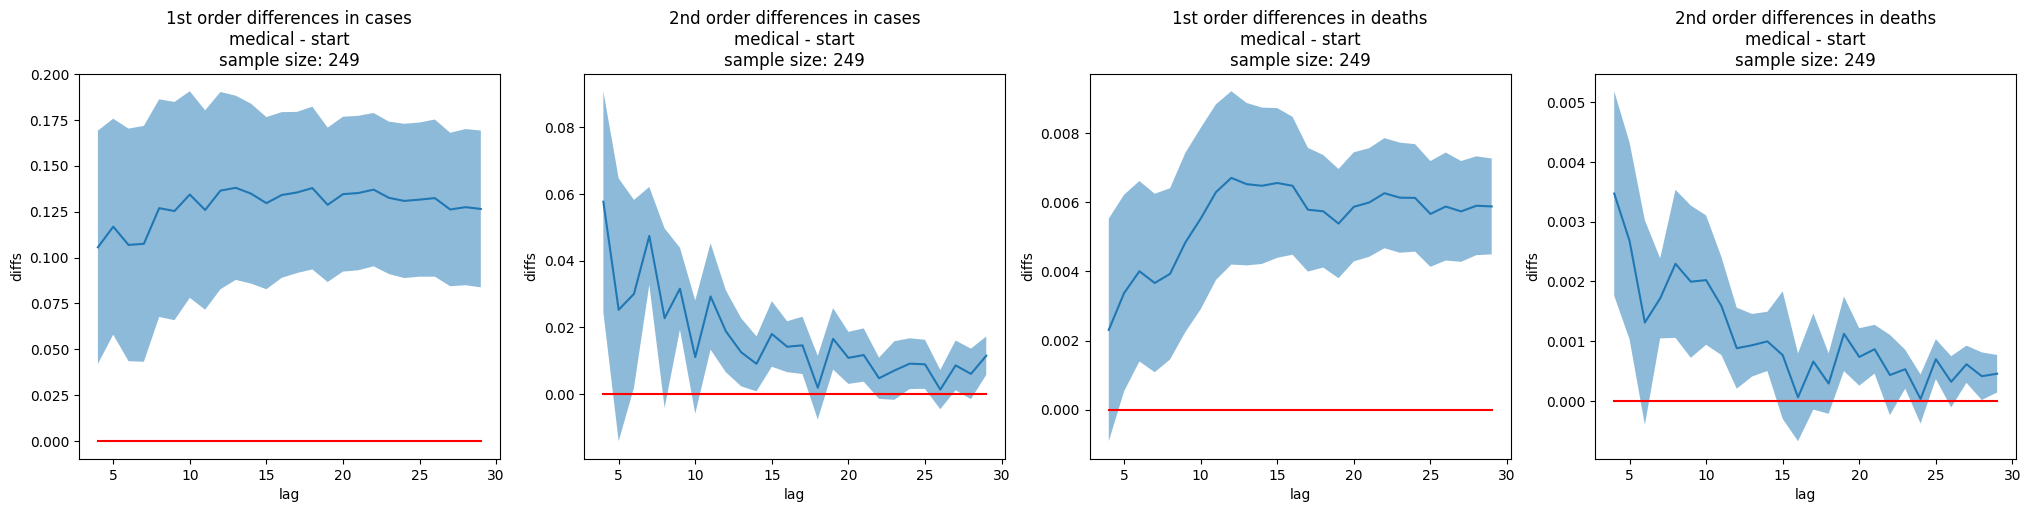

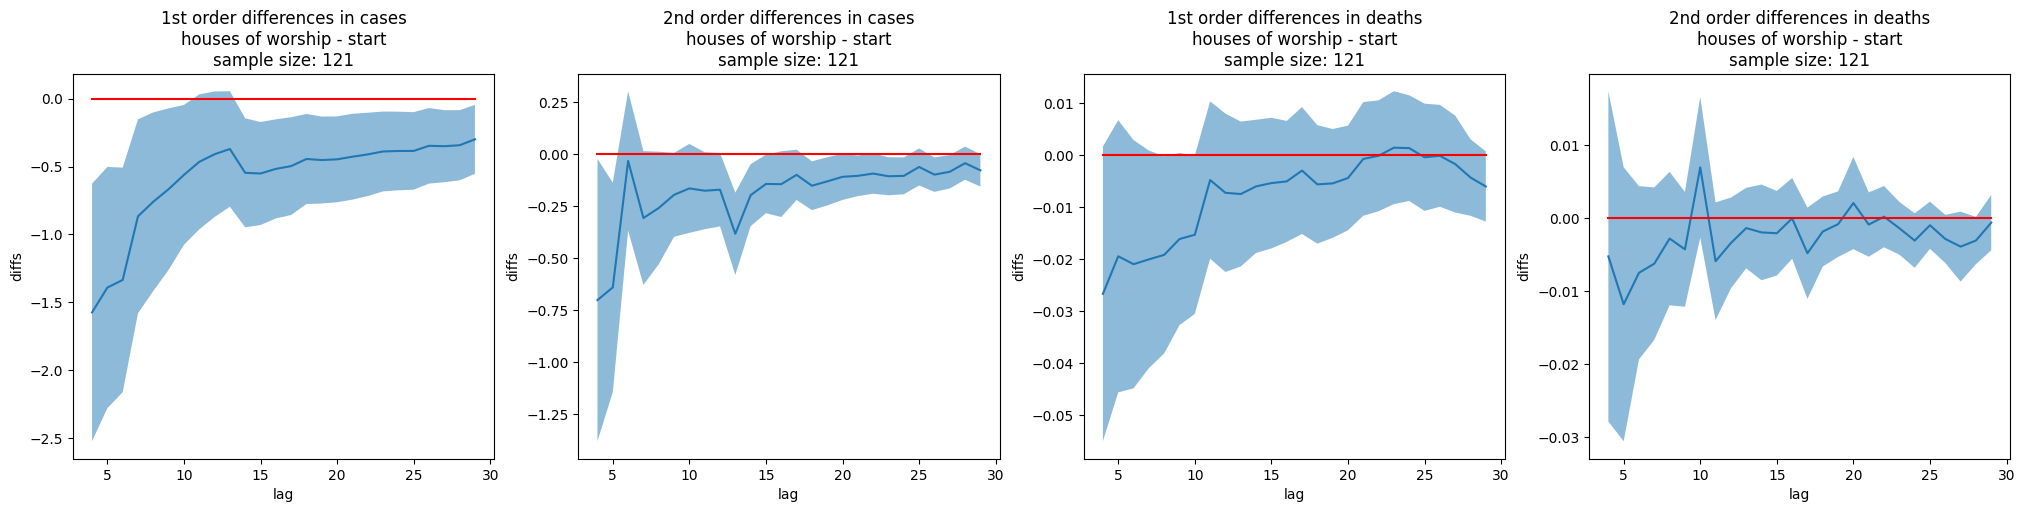

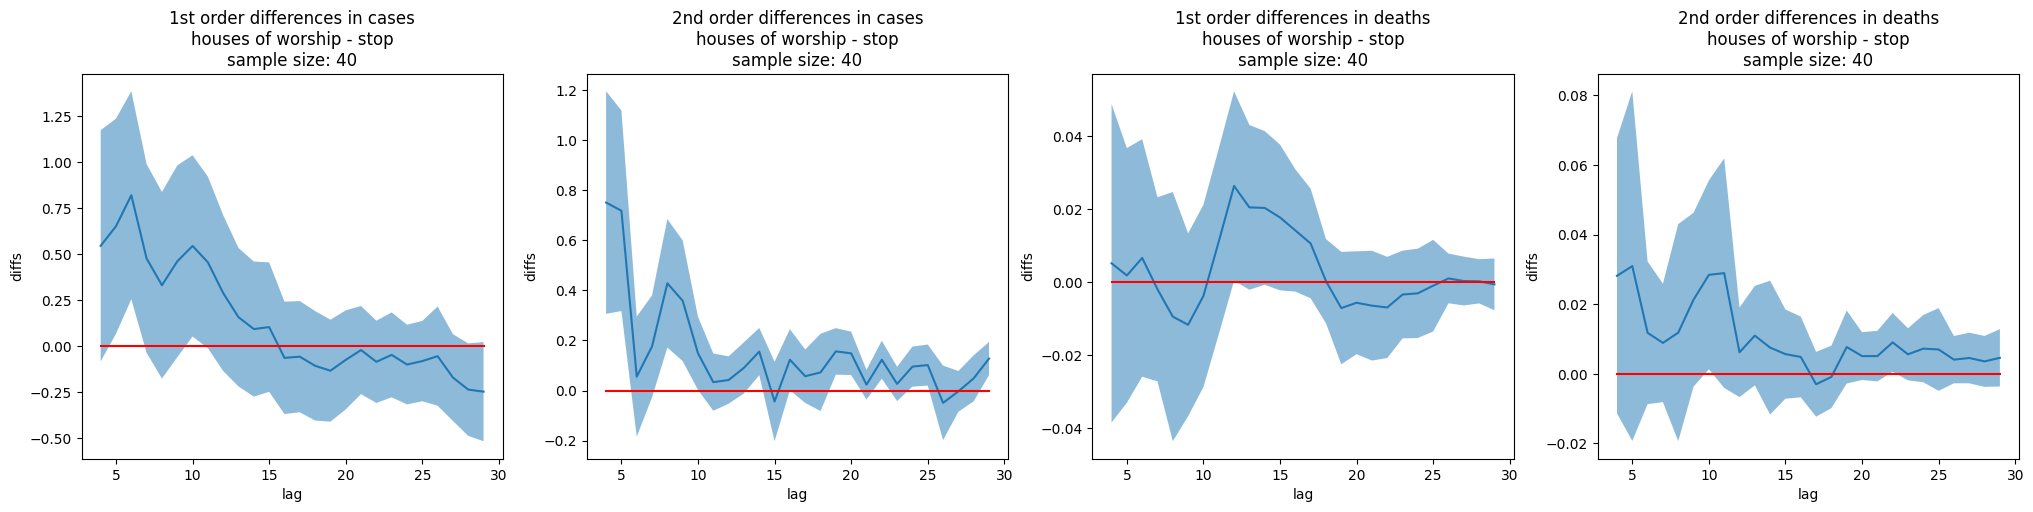

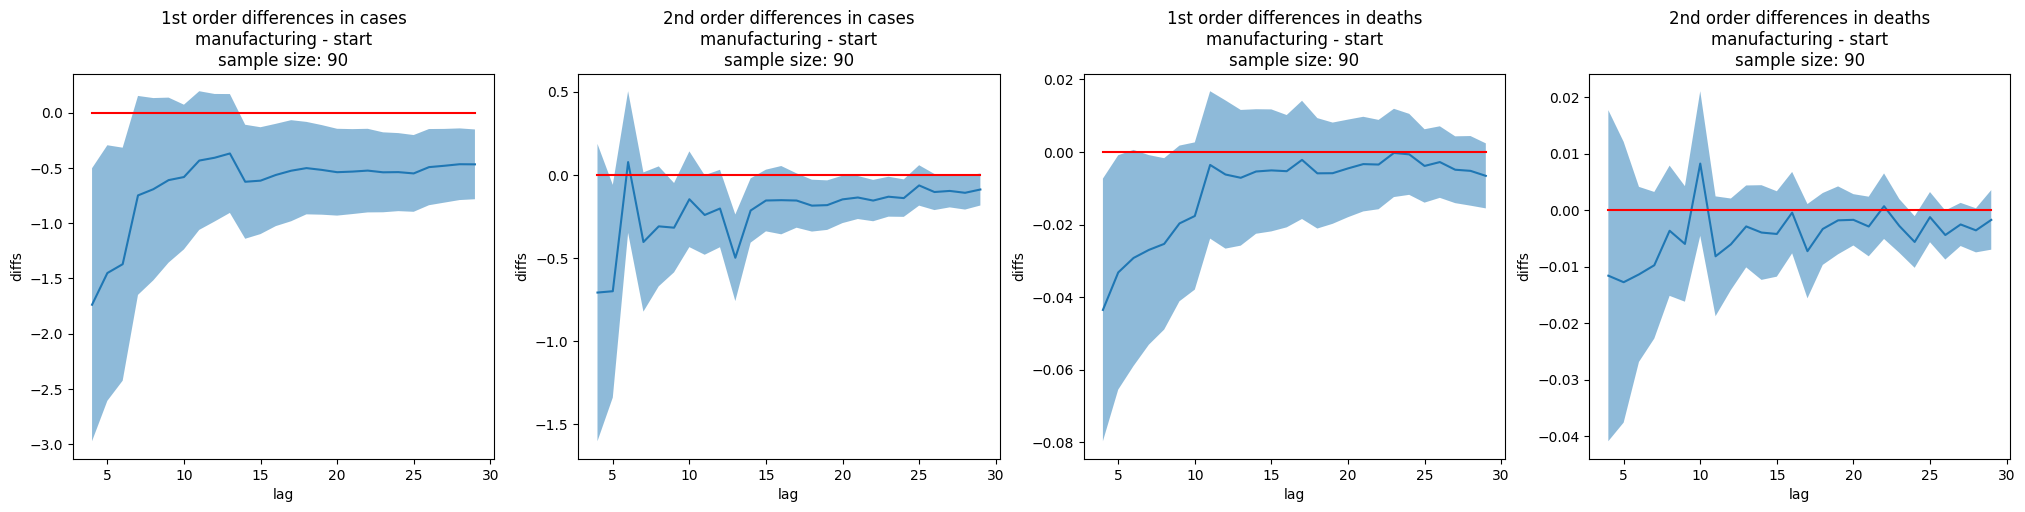

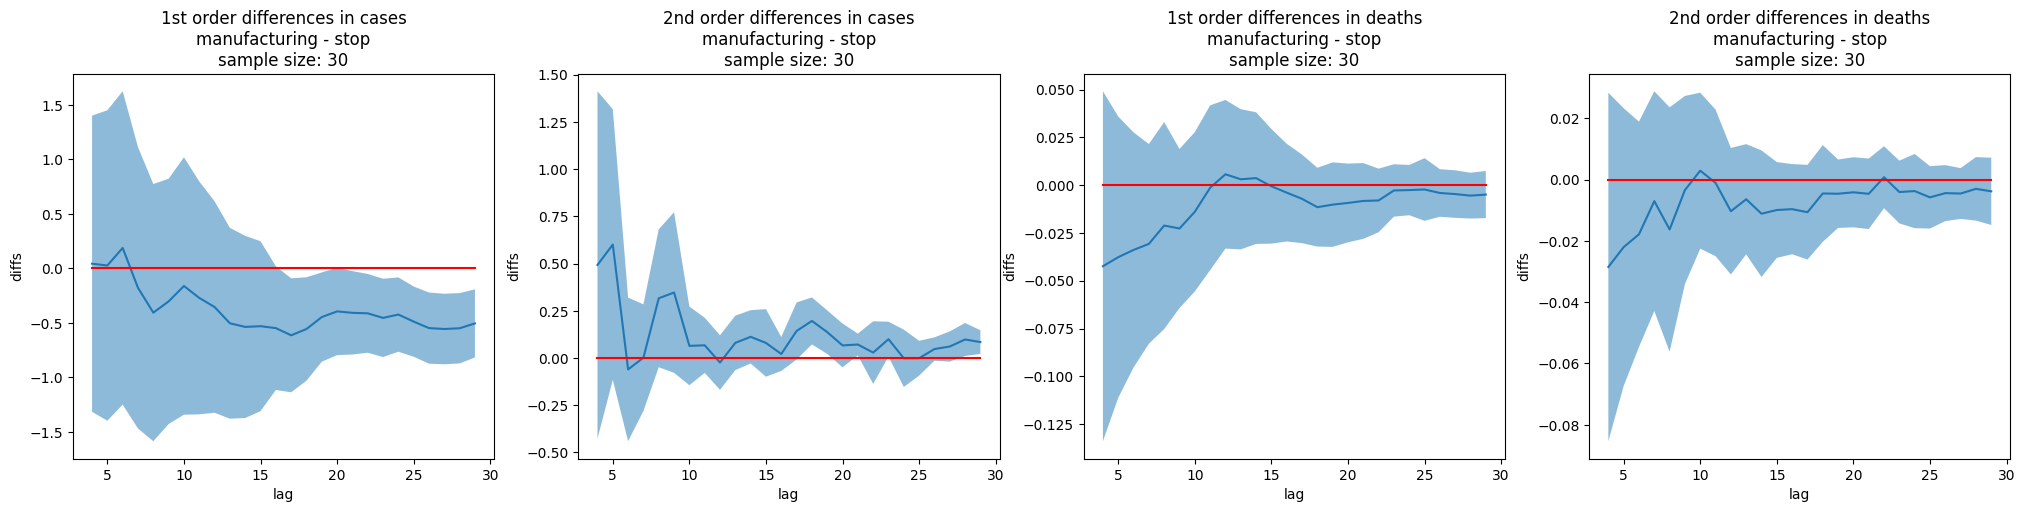

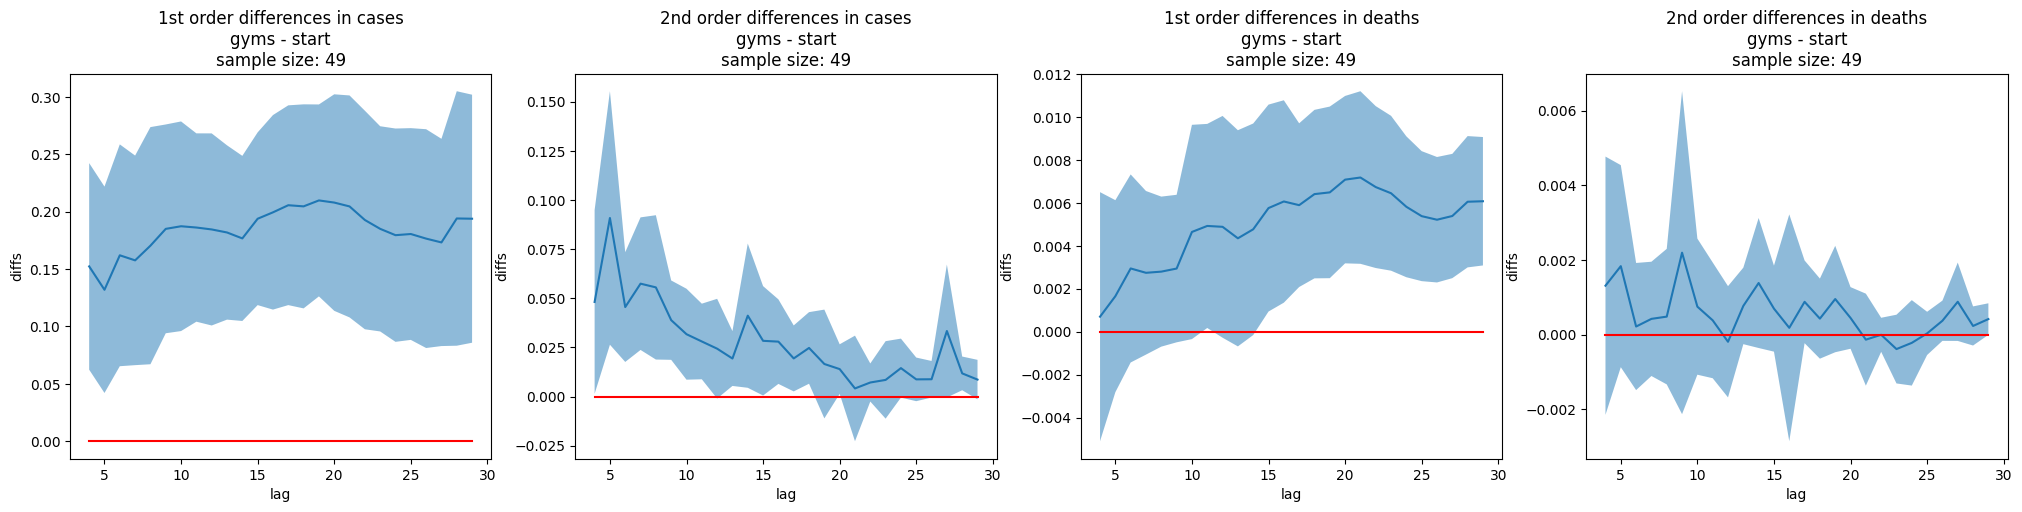

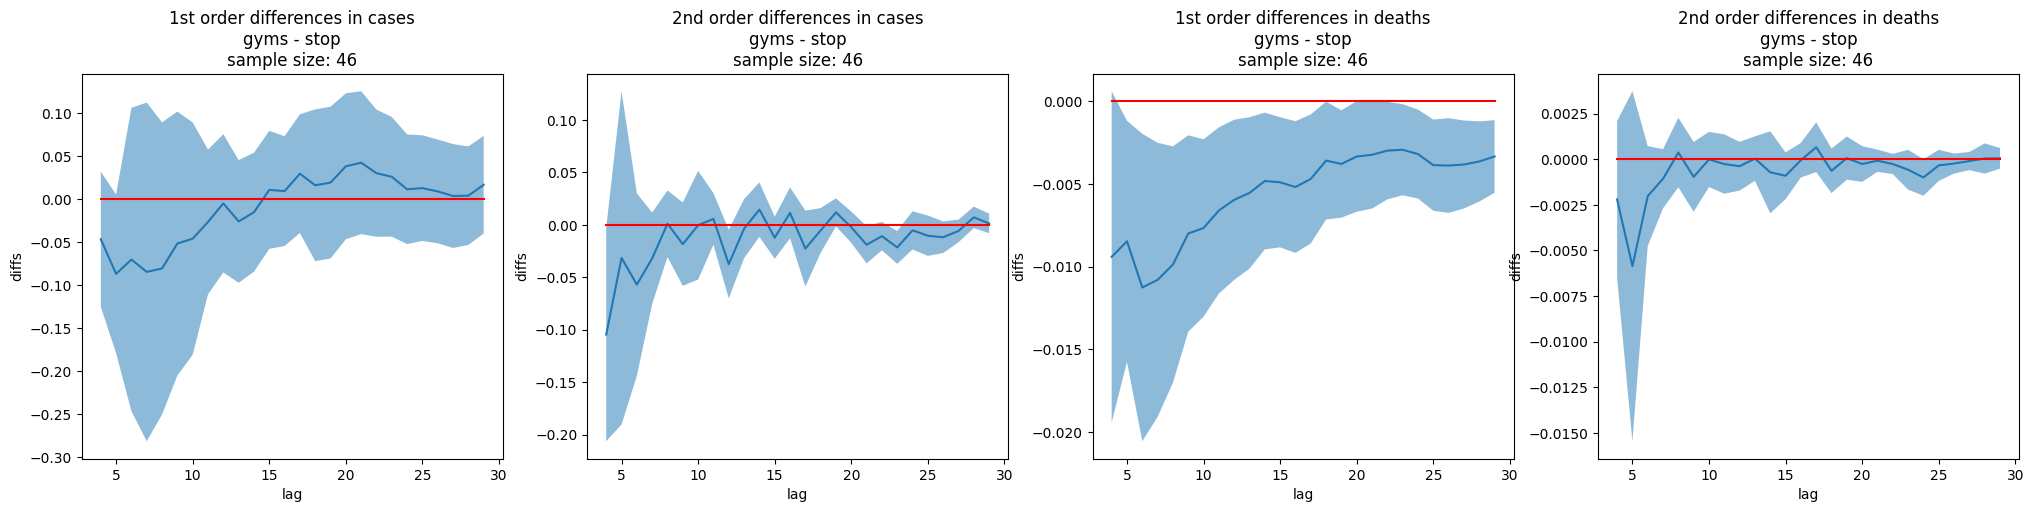

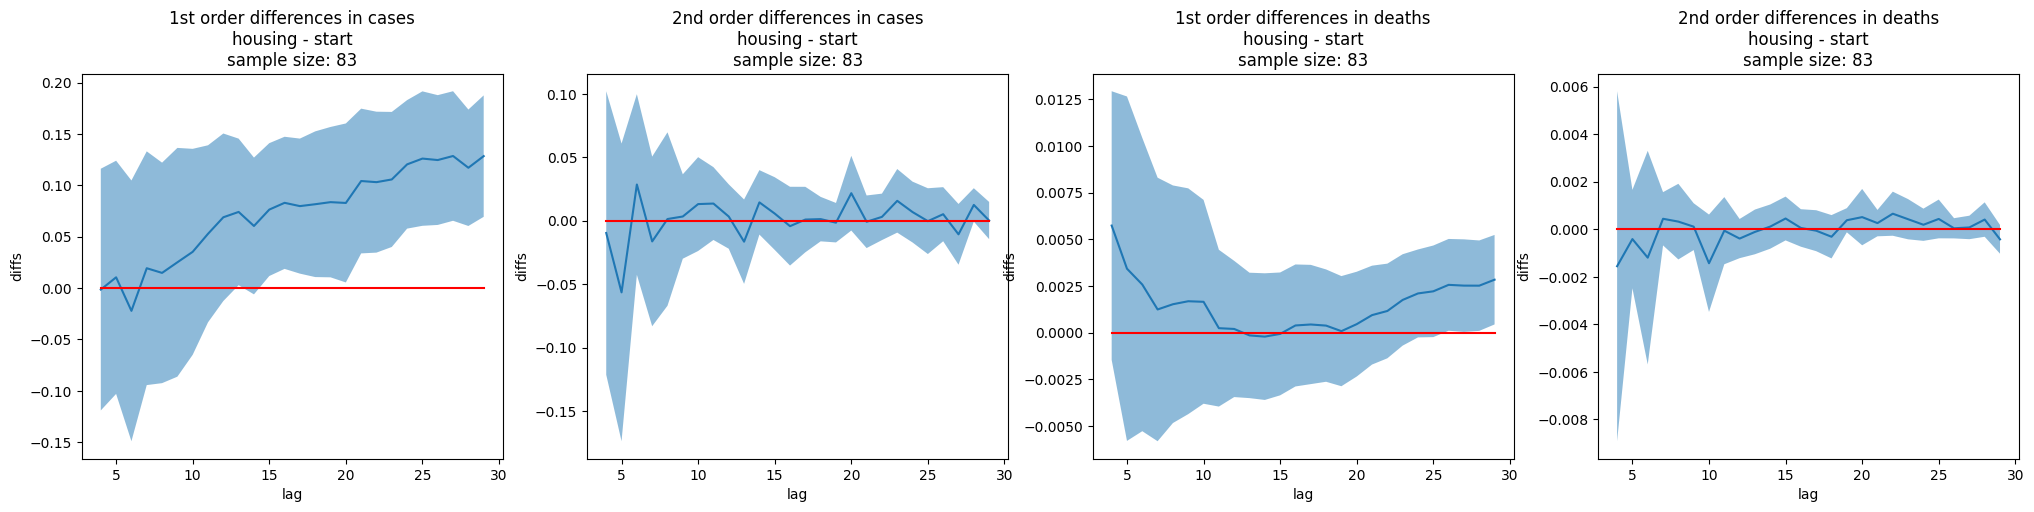

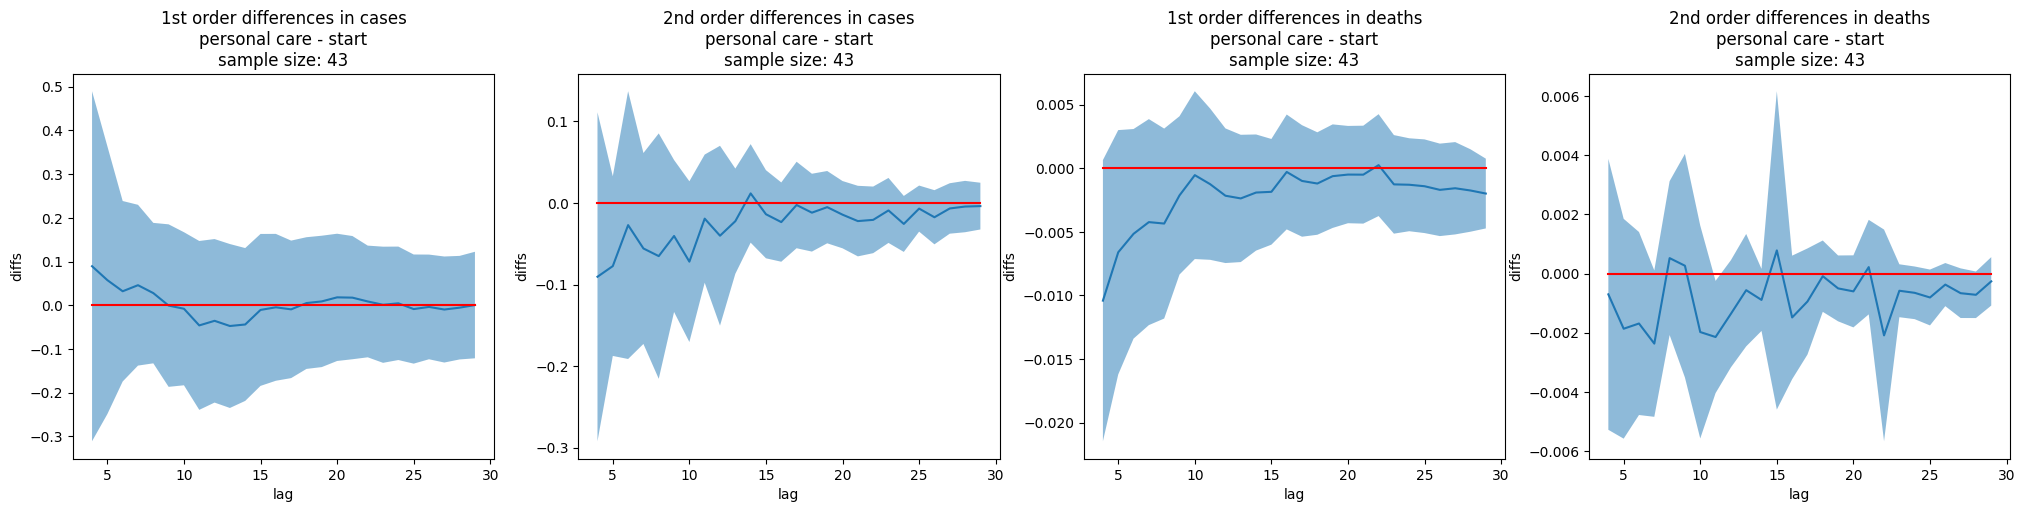

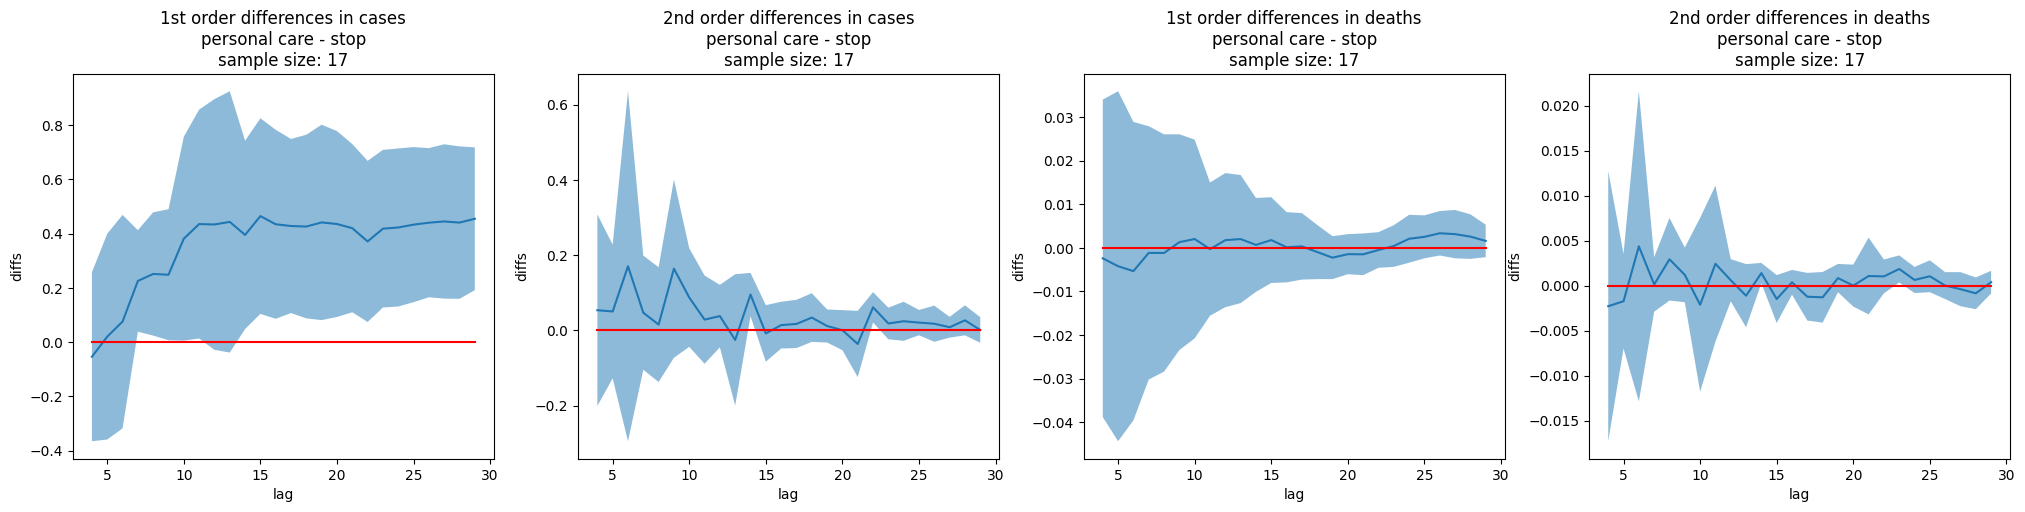

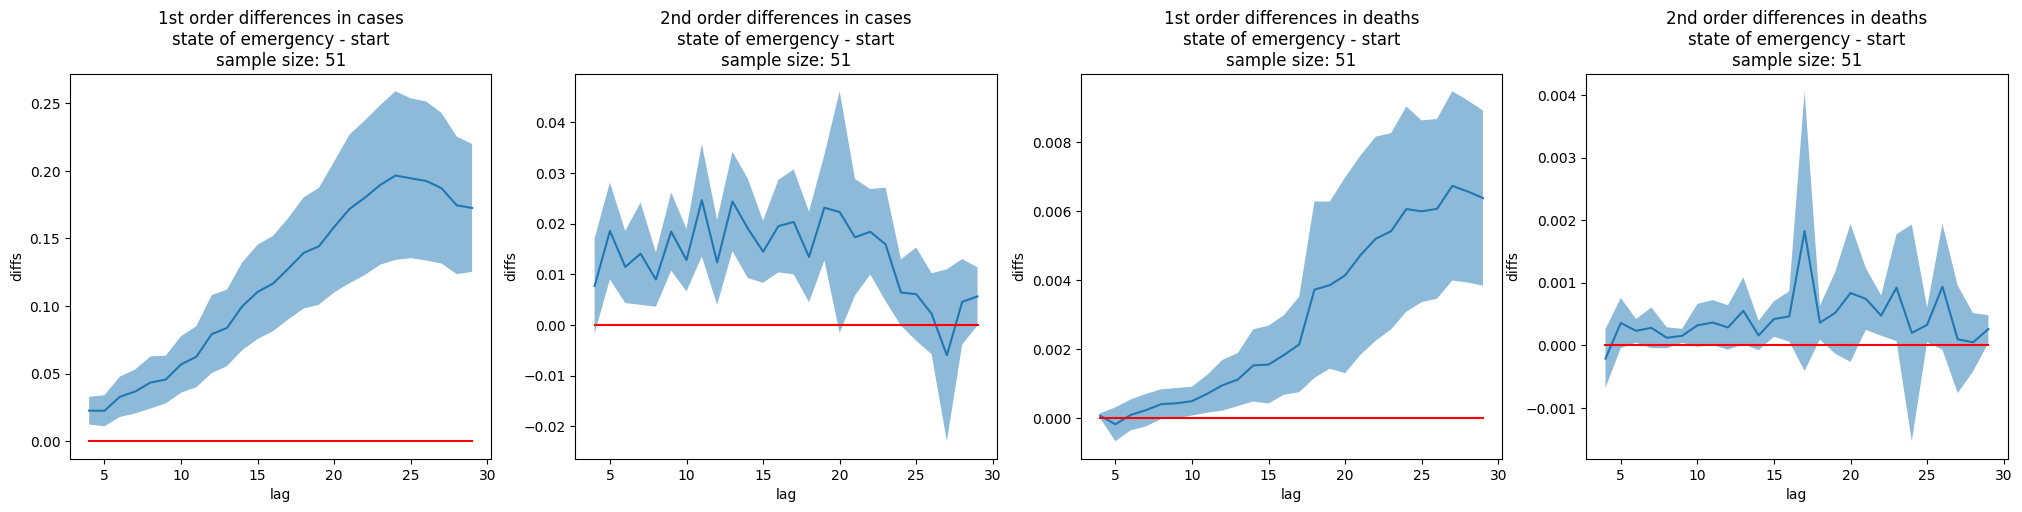

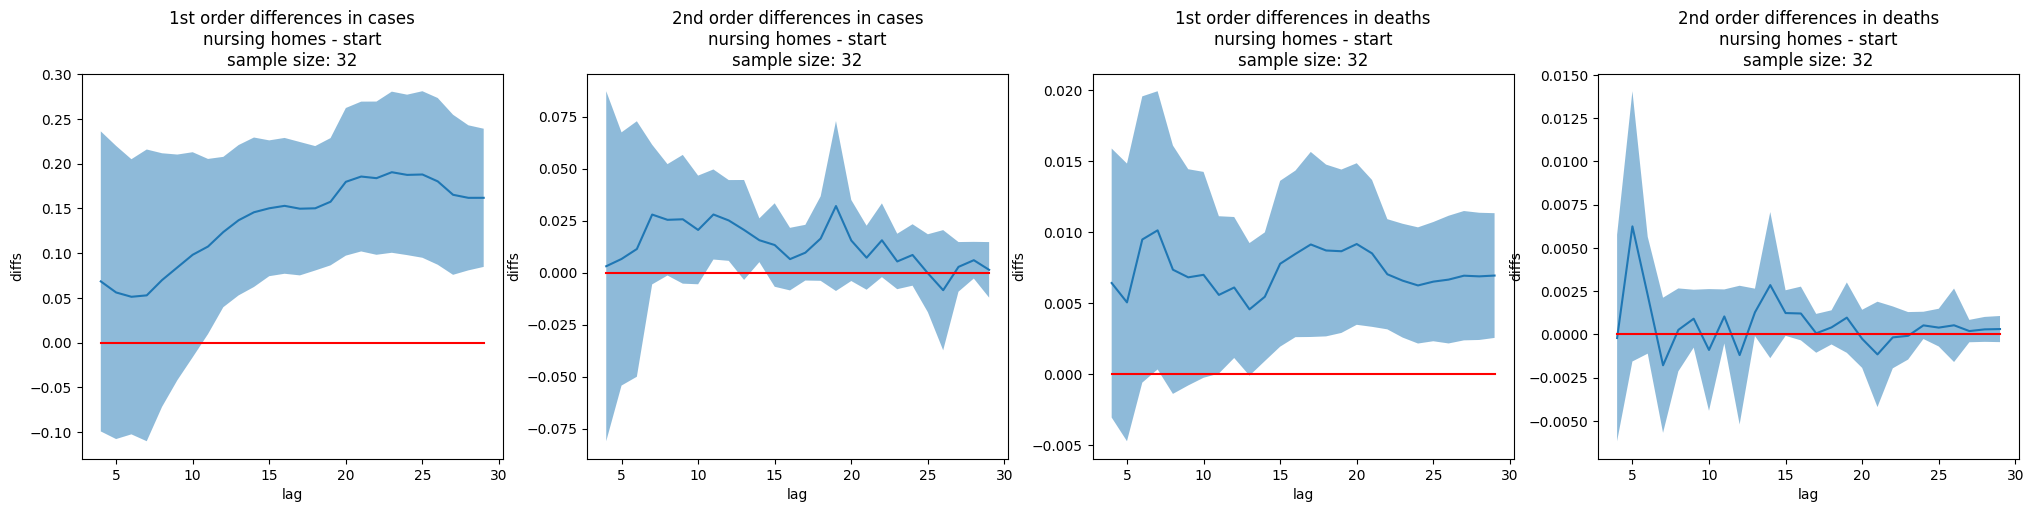

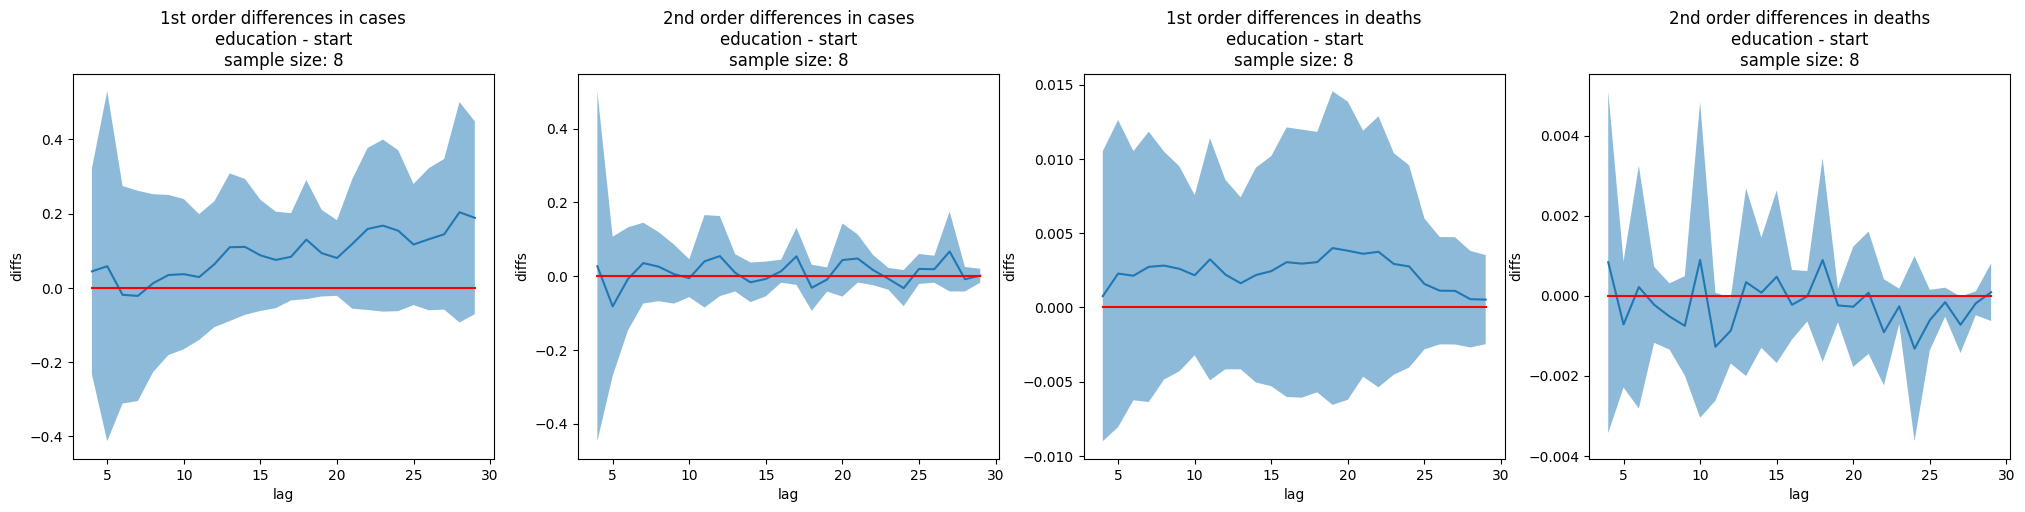

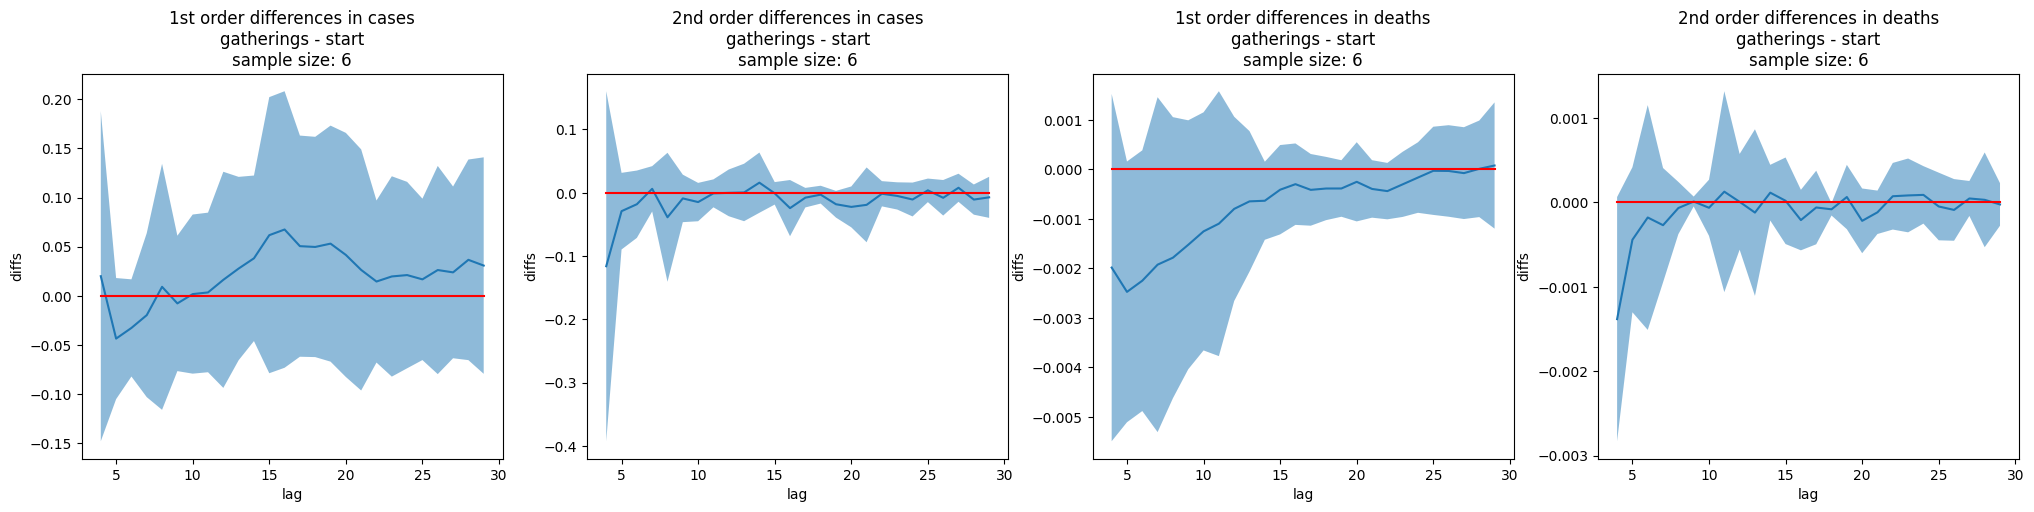

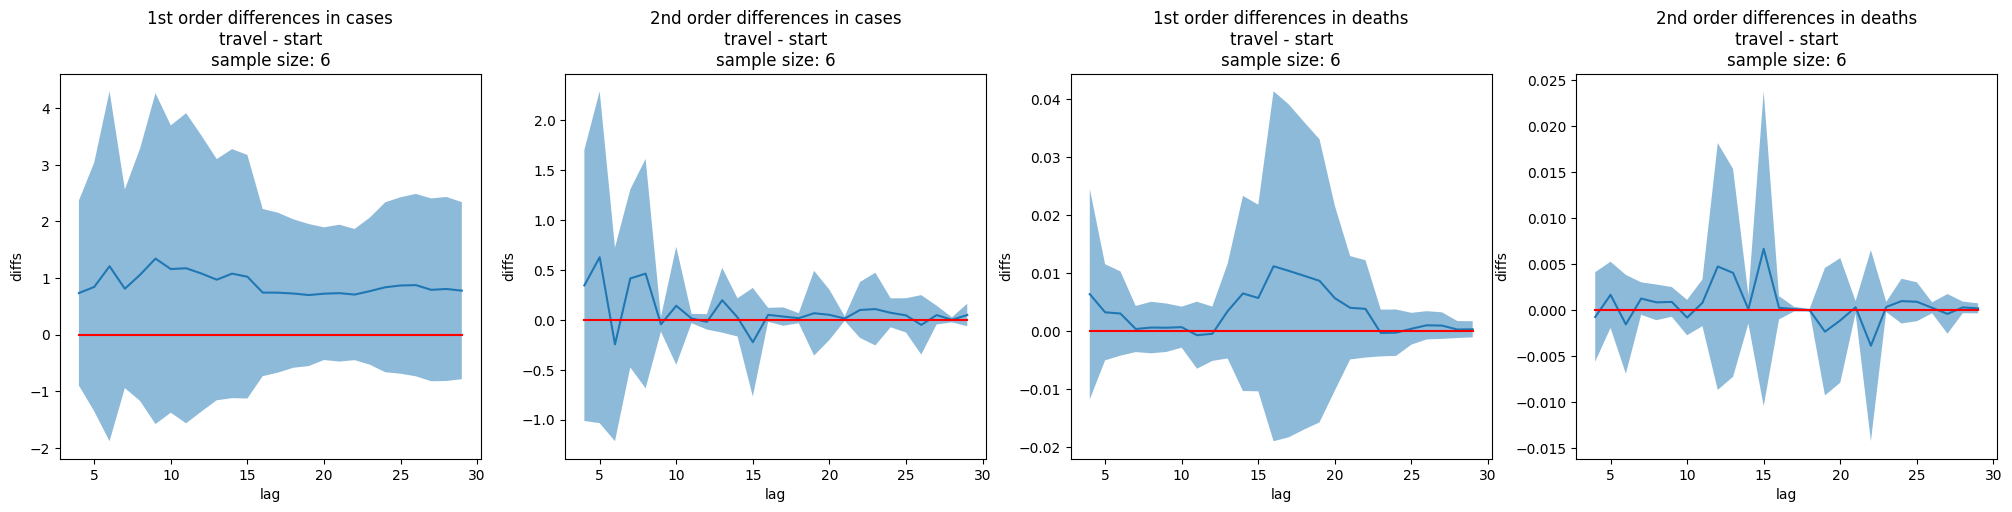

In [8]:
stats = deltas.calculate_diff_stats_v2(diffs_df)
policy_order = stats[['policy', 'sample_size']].groupby(['policy']).sum().reset_index().sort_values(by='sample_size', ascending=False)['policy']

for policy_type in policy_order:
    for start_stop in ['start', 'stop']:
        policy = policy_type + ' - ' + start_stop
    
        data = stats[stats['full_policy'] == policy].sort_values(by='lag')
        if len(data) == 0:
            continue
            
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
        
        for j, key in enumerate(['case_1st_order', 'case_2nd_order', 'death_1st_order', 'death_2nd_order']):
            axes[j].plot(data['lag'],
                                    data[f'{key}_mean'])
            axes[j].plot(data['lag'],
                                    [0]*len(data), c='r')
                
            axes[j].fill_between(data['lag'],
                             data[f'{key}_ci_lower'],
                             data[f'{key}_ci_upper'],
                             alpha = 0.5) 
            axes[j].set_xlabel("lag")
            axes[j].set_ylabel("diffs")
            title = f"{key.split('_')[1]} order differences in {key.split('_')[0]}s"
            axes[j].set_title(title + "\n" + policy + "\nsample size: " + str(data['sample_size'].values[0]))


There appear to be a few common patterns that are reappearing:

- 1st order differences remain positive over the entire lag period, but 2nd order differences drop after a few days: This is seen in `shelter in place - start` and `medical - start`.
- Significant decrease in 1st order case differences while 2nd order case differences stay flat: This is seen in `shelter in place - stop` and `childcare - stop`.
- Decrease in cases right after a policy was implemented, which tends towards zero as the lag period goes on: This is seen in `entertainment - start` and `childcare - start`.

Some policies seem to be consistently associated with an increase or decrease in cases/deaths over the entire lag period. A policy is considered to have a significant increase or decrease if, upon visual inspection, it appears that the CI is above or below the zero line for most of the lag period

**Policies associated with an increase in cases**
- shelter in place - start
- entertainement - stop
- medical - start
- gyms - start
- personal care - stop
- state of emergency - start
- nursing homes - start

**Policies associated with a decrease in cases**
- shelter in place - stop
- entertainement - start
- childcare - start
- houses of worship - start
- manufacturing - start


**Policies associated with an increase in deaths**
- shelter in place - start
- medical - start
- gyms - start
- state of emergency - start
- nursing homes - start

**Policies associated with a decrease in deaths**
- gyms - stop


There are also a few unexpected patterns. For example, shelter in place - start is associated with an increase in cases, when one would expect it to be associated with a decrease in cases. I suspect this is because most of these policies were put in place at the start of the first wave, so it may have been difficult for any one policy to curb the spread.

Some policies were associated with a sharp decrease in cases 4-8 days after being put in place. My initial assumption was that there would be some lag before the policy took full effect, since it usually takes a few days for COVID-19 to be detected when someone is infected.

Finally, the figure above represents multiple t-tests at the 95% CI (26 for each figure in Section 3). Since this allows for a type-I error rate of 5%, there are very likely many data points that are due to randomness in the data collection process and not a real result

# 4. Conclusion


In this notebook, I analyzed the 1st and 2nd order changes in cases and deaths after a number of different policies were implemented. I did find some policies that were significantly correlated with changes in cases and deaths, however, these results should be taken with caution since there are multiple confounding factors that are not accounted for here
